# Detecting Mussel Farms using Deep Learning
> * 🔬 Data Science
* 🥠 Deep Learning and Object Detection

## Table of Contents
* [Introduction](#Introduction)
* [Export training data](#Export-training-data)
* [Train the model](#Train-the-model)
    * [Necessary imports](#Necessary-imports)
    * [Get training data](#Get-training-data)
    * [Prepare data](#Prepare-data)
    * [Visualize training data](#Visualize-training-data)
    * [Load model architecture](#Load-model-architecture)
    * [Find an optimal learning rate](#Find-an-optimal-learning-rate)
    * [Fit the model](#Fit-the-model)
    * [Visualize results in validation set](#Visualize-results-in-validation-set)
    * [Accuracy assessment](#Accuracy-assessment)
    * [Save the model](#Save-the-model)
* [Deploy model and detect mussel farms](#Deploy-model-and-detect-mussel-farms)
    * [Model builder](#Model-builder)
    * [Model inference](#Model-inference)
* [Conclusion](#Conclusion)

## Introduction

Mussels are aquatic animals with bivalved hard shells that are consumed by millions of people around the world. Mussels grow in fresh water rivers or lakes near their openings to saline waters of the ocean, as well as in some coastal intertidal regions. Mussel aquaculture involves floating rafts that have ropes suspended in the water on which the mussels are cultured. The farmers collect mussel seeds from nearby rocky shores during low tides and attach them to the ropes in their rafts. Later, these ropes are covered with mesh socks that collect the mussels once they are ripe.

<figure>    
   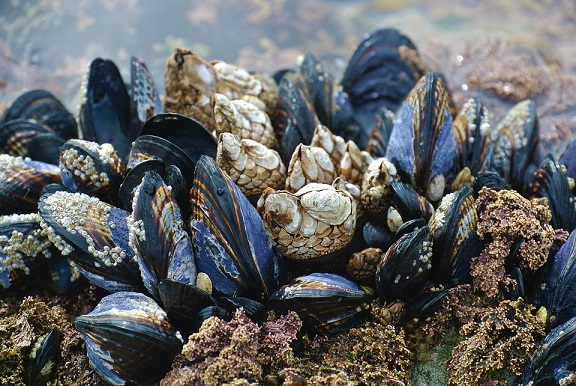
    <br>
    <center>
    <figcaption>Mussels growing on a rocky shore </figcaption>
    </center>
</figure>

Spain is one of the biggest producer of mussels in the world. The Galicia region in Spain accounts for almost 90 percent of the mussel aquaculture in the country. Our study area for this notebook is Ria de Arousa, which is the biggest mussel farming area in Galicia region.

<figure>    
   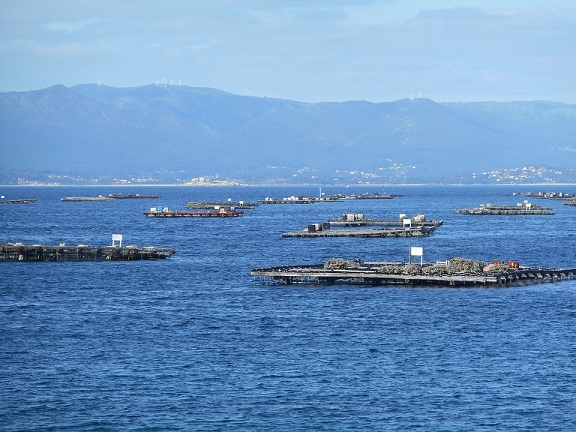
    <br>
    <center>
    <figcaption>Mussel Farms in Ria de Arousa, Spain </figcaption>
    </center>
</figure>

Monitoring of such aquacultures is an important aspect of maintaining the aquatic ecosystems. While sustainable farming can help the ecosystem, it's exploitation can degrade the environment quality and biodiversity. Therefore, it is important to monitor the growth of mussel farms in a region and their expansion into fragile areas. While physical surveys can be arduous and time consuming, satellite imagery and deep learning can help in monitoring mussel farming with much less effort. These analysis can also be helpful in comparing changes over longer periods of time.

In this notebook, we will train a deep learning model to detect mussel farms in high-resolution imagery of the Ria De Arousa region of Spain.

## Export training data

### Necessary imports

In [1]:
import os
import glob
import zipfile
from pathlib import Path

from arcgis.gis import GIS
from arcgis.learn import prepare_data, MMDetection

In [2]:
# Connect to GIS
gis = GIS('home')

The following imagery layer contains high resolution imagery of a part of the Ria De Arousa region. The spatial resolution of the imagery is 30 cm, and it contains 3 bands: Red, Green, and Blue. It is used as the 'Input Raster' for exporting the training data.

<Item title:"mussel_farm_training_imagery" type:Tiled Imagery Layer owner:demos_deldev>
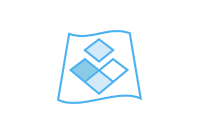

In [3]:
training_raster = gis.content.get('f2b92eed10394e5eb3c7f135861937d9')
training_raster

The following feature layer contains the bounding boxes for a few mussel farms in the Ria de Arousa region. It is used as the 'Input Feature Class' for exporting the training data.

<Item title:"MusselFarms" type:Feature Layer Collection owner:api_data_owner>
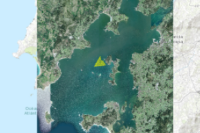

In [4]:
training_feature_layer = gis.content.get('ff6a48b3391c4a24b807af0eb08bb6c1')
training_feature_layer

Training data can be exported by using the 'Export Training Data For Deep Learning' tool available in [ArcGIS Pro](https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/export-training-data-for-deep-learning.htm) and [ArcGIS Enterprise](https://developers.arcgis.com/rest/services-reference/export-training-data-for-deep-learning.htm). For this example, we prepared the training data in the 'PASCAL Visual Object Classes' format, using a 'chip_size' of 448px and a 'cell_size' of 0.3m, in ArcGIS Pro. The 'Input Raster' and the 'Input Feature Class' have been made available to export the required training data. We have also provided the exported training data in the next section, if you wish to skip this step.

<figure>    
   <img src='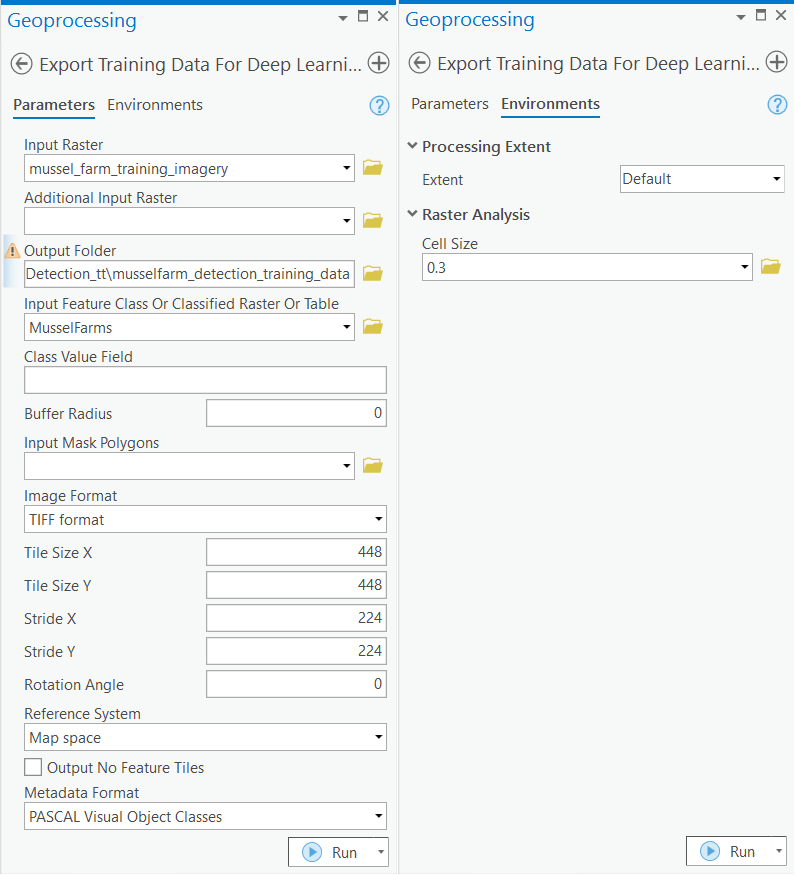 '>
    <br>
    <center>
    <figcaption>Export Training Data for Deep Learning </figcaption>
    </center>
</figure> 

## Train the model

### Get training data

We have already exported the data that can be directly used by following the steps below:

<Item title:"musselfarm_detection_training_data" type:Image Collection owner:api_data_owner>
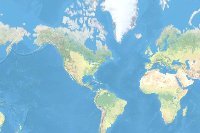

In [5]:
training_data = gis.content.get('57cb821dedca4c5598e81c8d2d510c91')
training_data

In [6]:
filepath = training_data.download(file_name=training_data.name)

In [7]:
# Unzip training data
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

In [8]:
data_path = Path(os.path.join(os.path.splitext(filepath)[0]))

### Prepare data

We will specify the path to our training data and a few hyperparameters. 

- `path`: path of the folder/list of folders containing training data.
- `batch_size`: Number of images your model will train on each step inside an epoch. Depends on the memory of your graphic card.
- `chip_size`: The same as the tile size used while exporting the dataset.

In [9]:
data = prepare_data(data_path, batch_size=4, chip_size=448)

### Visualize training data

To get a sense of what the training data looks like, the `show_batch()` method will randomly pick a few training chips and visualize them.

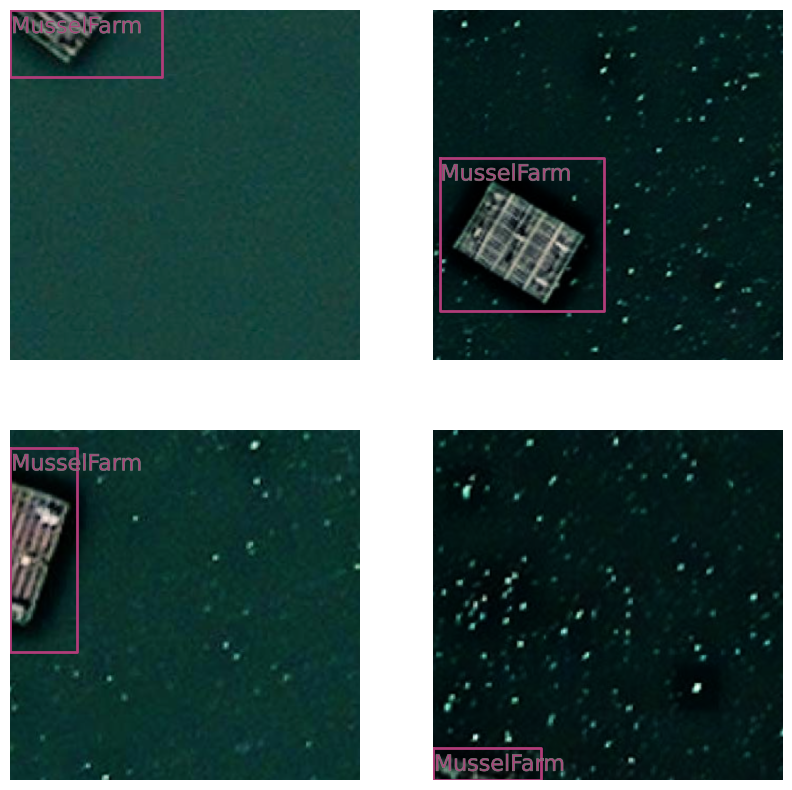

In [10]:
data.show_batch(rows=2)

### Load model architecture

Through the integration of the MMDetection library, `arcgis.learn` allows the use of the Dynamic RCNN model, along with many other models. For more in-depth information on how to use MMDetection, please see [Use MMDetection with arcgis.learn](https://developers.arcgis.com/python/guide/use-mmdetection-with-arcgis-learn/).

In [11]:
MMDetection.supported_models

['atss',
 'carafe',
 'cascade_rcnn',
 'cascade_rpn',
 'dcn',
 'detectors',
 'dino',
 'double_heads',
 'dynamic_rcnn',
 'empirical_attention',
 'fcos',
 'foveabox',
 'fsaf',
 'ghm',
 'hrnet',
 'libra_rcnn',
 'nas_fcos',
 'pafpn',
 'pisa',
 'regnet',
 'reppoints',
 'res2net',
 'sabl',
 'vfnet']

In [12]:
model = MMDetection(data, 'dynamic_rcnn')

### Find an optimal learning rate

Learning rate is one of the most important hyperparameters in model training. The ArcGIS API for Python provides a learning rate finder that automatically chooses the optimal learning rate for you.

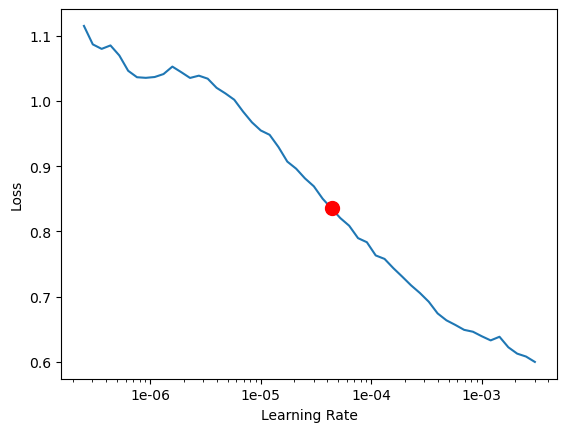

4.365158322401661e-05

In [13]:
lr = model.lr_find()
lr

### Fit the model 

Next, we will train the model for a few epochs with the learning rate found above. Given the small size of the training dataset, we can train the model for 10 epochs.

In [14]:
model.fit(10, lr=lr)

epoch,train_loss,valid_loss,average_precision,time
0,0.657232,0.551822,0.746600,01:06
1,0.412948,0.421975,0.825002,01:06
2,0.346688,0.336524,0.847761,01:07
3,0.305406,0.351150,0.849114,01:06
4,0.301727,0.347651,0.850602,01:06
5,0.284532,0.346730,0.866180,01:06
6,0.277933,0.309670,0.858802,01:06
7,0.277370,0.293810,0.883472,01:05
8,0.253609,0.284540,0.883564,01:06
9,0.285145,0.277822,0.891327,01:08


As we can see, the training and validation losses were decreasing until the 9th epoch, before increasing slightly in the last epoch. As such, there could be room for more training.

### Visualize results in validation set

It is a good practice to see the results of the model viz-a-viz ground truth. The code below picks random samples and shows us ground truth and model predictions, side by side. This enables us to preview the results of the model we trained.

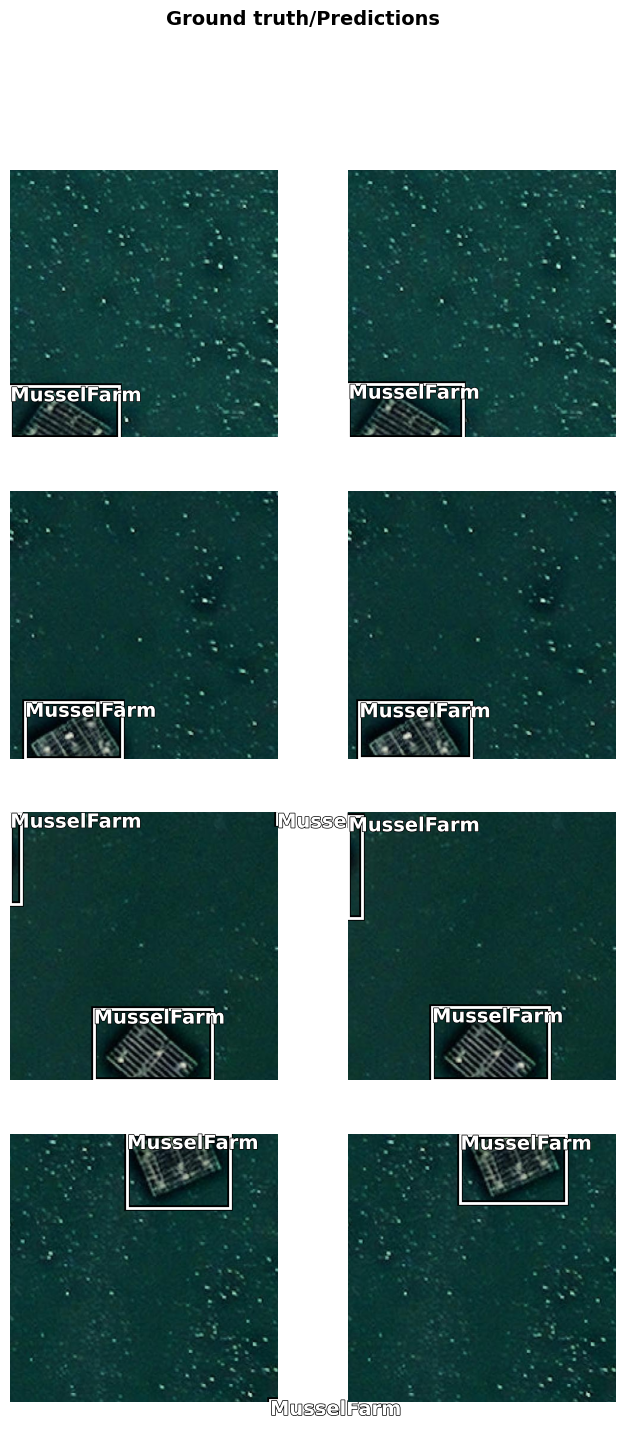

In [15]:
model.show_results()

### Accuracy assessment

`arcgis.learn` provides the `average_precision_score()` method that computes the average precision of the model on the validation set for each class.

In [16]:
model.average_precision_score()

{'MusselFarm': 0.8913268297731172}

### Save the model

We will save the trained model as a 'Deep Learning Package' ('.dlpk' format). The Deep Learning package is the standard format used to deploy deep learning models on the ArcGIS platform. 

We will use the `save()` method to save the trained model. By default, it will be saved to the 'models' sub-folder within our training data folder.

In [17]:
model.save('musselfarms_mmd_dynamic_rcnn_10ep')

Computing model metrics...


WindowsPath('~/AppData/Local/Temp/musselfarm_detection_training_data/models/musselfarms_mmd_dynamic_rcnn_10ep')

## Deploy the model and detect mussel farms

We can now use the saved model to detect mussel farms in the entire Ria De Arousa region. Here, we have provided only a sample raster for Ria De Arousa. The following imagery layer contains high resolution imagery of a part of the Ria De Arousa region. The spatial resolution of the imagery is 30 cm and contains 3 bands: Red, Green, and Blue.

<Item title:"mussel_farm_detection_test_imagery" type:Tiled Imagery Layer owner:demos_deldev>
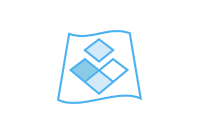

In [18]:
#get raster data using item id
sample_inference_raster = gis.content.get('d6f035f5de504c86855e0ee70e83ad0e')
sample_inference_raster

### Model builder

To save time and resources, we will only run the model on the water body and not the surrounding land masses, as the mussel farms are only found in water. To extract a raster with only the water body, we created a water mask using the Sentinel-2 Views NDWI. The following model builder can be used to create a water mask and detect the mussel farms.

<Item title:"Model Builder for Mussel Farm Detection" type:Geoprocessing Sample owner:api_data_owner>
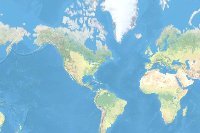

In [19]:
model_builder = gis.content.get('2647a386f5a04917b74cc4f40a48f57f')
model_builder

Tools used:
- Copy Raster: Copies a region of the [Sentinel-2 Views NDWI](https://www.arcgis.com/home/item.html?id=112db40d3640473aacb0d1f891462496) hosted imagery and creates a subset to be processed further.
- Greater Than Equal: Creates a binary raster with water pixels as 1 and others as 0.
- Reclassify: Reclassifies the other pixels (value 0) in the binary raster as 'No Data'.
- Raster to Polygon: Converts the raster into a feature layer with polygons representing the water mask.
- Fill Gaps: Fills gaps smaller than 1500 square meters (approximate maximum area of a mussel farm) in the water mask.
- Extract By Mask: Uses the water mask to clip the original raster and create a new raster containing only the water body.
- Detect Objects Using Deep learning: Detects mussel farms on the clipped raster using the model we trained earlier.

<figure>    
   <img src=' data: image/jpeg;base64,/9j/4AAQSkZJRgABAQEAeAB4AAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCALEAs4DASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9QKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACisDxD460TwvHu1DUIYWxkR7ssfoBya8z1z9pWyhZk0rTZbn/ppM2xf6n9BXTTw9Wt8EbnJWxdDD/xJpfn9x7XRXzFqX7Q3ie84t1tbNf9hCzfmTj9KxpvjV4xm/5jDIP9mJP6rXdHK673sjzJZ1hY7Xfy/wCCfW1FfIkPxi8YwnK63Kf96OM/+y1o2nx68X2rhmvIbgD+GaEYP5YpvK666r+vkSs7wz3TXyX+Z9VUV8/aV+0xexsBqOkRSr3a3kKn8jn+dei+HfjZ4X8QlU+2fYJ2OBHeDZz9en61yVMHXpayj+p30cww1bSM9fPT8zvKKbHIsyB0ZXRhkMpyDTq4j0QooooAKKKKACiiigAooooAKKKRmEalmOFUZJpXtqwForlNS8WStIyWgCIDjzGGSfcVnf8ACQ6j/wA/Lf8AfI/wr4+vxVgKM3CKlK3VJW/Fo744KrJXeh3lFcH/AMJDqP8Az8t/3yP8KP8AhIdR/wCflv8Avkf4Vz/63YL/AJ9y/D/Mv6jU7o7yiuD/AOEh1H/n5b/vkf4Uf8JDqP8Az8t/3yP8KP8AW7Bf8+5fh/mH1Gp3R3lFcH/wkOo/8/Lf98j/AAo/4SHUf+flv++R/hR/rdgv+fcvw/zD6jU7o7yiuD/4SHUf+flv++R/hR/wkOo/8/Lf98j/AAo/1uwX/PuX4f5h9Rqd0d5RXB/8JDqP/Py3/fI/wo/4SHUf+flv++R/hR/rdgv+fcvw/wAw+o1O6O8orjrHxZdQuBcYnj78AN+ldbb3Ed1CksTbkYZBr6DLs2wuZp+weq3T3OWrQnR+Ikooor2TnCiiigAooooAKKKKACiiigAoooJwMngUAFFY+o+MNE0n/j71W0hb+6ZQW/Ic1gz/ABk8KQsQNQeUj/nnbyf1FYSxFKGkppfM55YijT0lNL5nbUV563xy8MqwAN4w9RDx/OrEXxq8Kyfeu5ov963f+gNZ/XMP/OvvM/rmGf8Ay8X3ndUVzun/ABE8N6oVEGsW25uiyt5Z/JsVvwzR3EYeKRZUPRkII/OuiNSE9YO50QqQqawaY+iiirNAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKo61rFtoOl3F/duI4IELsTTSbdkJtJXYzXvEFj4b0+W9v51ghjGcsevsPevnzxx8fdS1iSW20UGws84ExH71h6+1ch8QfH99471d55nZLKNiLe37Kvqfc1ytfUYXL400p1Vd9ux8Vjs2nVbhQdo9+r/yH3FxLdTNLNI0srHLO5JJ/GmUUV7J86FFFFMAooooAKKKKAOr8H/EzXfBciiyumltM82sxLRn6en4V9E/Dv4s6X48iWAH7Fqirl7WQ/e9Sh/iH618l1La3U1jcRz28rQzRtuSRDhlPqDXnYjBU8Qr2tLuetg8yrYVpXvHt/kfdFFed/B/4nDx1pj216VTWLUZkUceanA3gfXgj6eteiV8lUpypTcJ7o+8o1oV4KpB6MKKKKyNgooooAKKKKACsjxTM0OksFOPMYIfp1/pWvWH4v/5Baf8AXUfyNePnEnHL6zj/ACs3w+tWPqcdRRRX4IfTBRRRQAUUUUAFFFFABRRRQAUUUUAFdV4NnZoLiEnKowYfjn/CuVrpvBf3rz/gH/s1fT8Nycc0pJdb/wDpLOPF/wAFnT0UUV+2HzwUUUUAFFFFABRRRQAVBfX1vptrJc3UyW8EYy0kjYUfjWb4r8VWPg/Snvb1uPuxxL96RvQf54r5w8XeNtS8ZXpmvJNkAP7u2QnYn+J968zGY6GFVt5dv8zy8Zj4YRcu8u3+Z6f4q+O1ta74NDt/tUnT7VOCIx9F6n9K8u13x1rviMsL3UJWiP8AyxjOxP8Avkf1rBor5StjK1f4paduh8jXxtfEP35adlsFFFFcRwhRRRQAVf0rXtR0ObzbC9mtH/6ZOQD9R0NUKKpScXdMcZOLunY9V8M/Hi/tZFi1q3W9h4HnQgJIPcjof0r13w94q0vxRb+dp12k+Blo+jp9V6ivk2rWm6pd6PeJdWU721wn3ZIzg17GHzSrS0qe8vxPaw2a1qTtU95fifX1FcF8N/idD4whFnebLfVkH3RwswA5ZffrkV3tfV0qsK0FODuj6+jWhXgp03dBRRRWxsFFFFABRRRQAUUUUAFFUda1qx8P6fLfajcpa2sf3pH/AJAdz7Cvnfx78fNU16SS10Utpen/AHfMB/fSe+f4R7D867MPhamIfuLTucGKxtLCL33r26nuPib4jeHvCIZdR1KNJx/y7xfPL/3yOn44ry7Xv2mgrMmjaRuGTia9fr/wBf8AGvCpJHmkZ5GZ3Y5LMckmm19BSy2jD4/eZ8pWzjEVHan7q/E9B1L47+MNQBCX8dkh/htoFH6kE/rWHP8AEvxXcfe8Q6gP+udwyfyIrmqK9CNClHaC+48qWKrz+Kb+9m4njzxLG25fEOqA/wDX7J/8VV+2+K3i61YFNfvGI/56MJP/AEIGuUoqnSpveK+4lV6sdpv72eo6X+0V4os2UXSWeoJ38yLYx/FSB+legeHv2j9E1Damq2k+lycZkX97H+gyPyr5uorkqYDD1Ps29DupZpiqT+K/rr/wT7g0nW9P161Fzp15DewH+OFwwHsfQ/WrtfEeh+ItS8N3i3WmXktnMOpjbAPsR0I+te+fDX482+vSRabr4js75jtS6X5YpD2BH8J/T6V4eIy6pSXNDVfifSYTN6VdqFX3ZfgewUUUV5B74UUUUAFFFFABRRRQAUUUUAFeD/tJeKnWSy0CFsKV+0T4PXnCj9CfwFe8V8qfHmR2+JV+H6LHEF+mwH+ZNeplsFPEK/TU8XN6jp4VpdXY89or561Dw/b+E7q48R6todprenyapJep490K8jfVLRDcLsSUOgbylBMJEUkmUUjZgkV0eo/GHW18cX1lp+mzXem6fqcWmy2cOgX88swYJ5kwvEHkRBPMzsYEkRn5l3DH00K6lZS0b6fd+rt/Tt8bLDvXkd1/Xr+NvOx7FRXjmk/E3xbc6pp9zdf2L/Y194ju9AS2htZhcIIzOEmMplKk5hAKbOeoYZwOT8O+Kta03RvD+p6tLaa7q0LeIpre8mSdWiEJfCYMzblJXHPRdqjBG4xLFQjD2ltP+Gf5ST/4I/qs+blvrt/6V+sWj6PorxVfjB4l8N6fdXfiGDS9R3eGxr9vDpdvNCYn3KphYs8hkGXX51VTwflOeMfxR441vxJ4I1ux1e2klW3udKnh1JdBvdJhctexBofLuslmUqDuVsEOOAQc6SrRjp1/ybT/ACfl+BMcPKVnfS619bf5r+rn0FRXE+Ita8J+KNH1e28QW90uj6YwlvRq2n3VraybGOBukRUuEyPuqXVvl4ORVL4K6HNo+g6rMumNoOk6hqMl5peivGIjZWzKgC+WOIt7K8vljG3zMEA5FXGfNKy2tf8Ar8bejMnT5Ycz0d7f1/XX0PQ6K+eJoW0/R9c+FCHyzf8AiH7LbIpIb+zLnN1KeOgCC5jB9QKvr8QpfCE2paXounwadPeeJby3+0Q6Xe6mqJFBGzObeFi7O2VXCsigZPbDYrELqrafj7uny5lrfc3lhXtF31/DWz+dnoe8UV48vxe8QrpNlJc6OtlfahY3CWiXllcW4e+juEgTdG+HWKQSpIFIDAZGT1D2+KnifWNBvdR0XSoZI7ZLCGcpZy3clvPIN903kJIjyrErRjy0IcksecbTft4f18/u+eyab3I+rVP6/r+rM958FeJpvCPiax1OJiFikAlUfxRnhh+VfaEUizRpIh3I4DKw7g9DX52fDnxU/i7w2Lya5trq6inltp2tbae1w6ORhoJwJIXxglGzjPDMME/Z3hbxT4qTwxo6xeDZLuMWcIW4/tKFPMGwYbB5GeuDXi5rFNQqLr/w6Po8knKMqlGXT89mej0Vxf8Awlni7/oRZP8Awa29H/CWeLv+hFk/8GtvXzx9WdpRXF/8JZ4u/wChFk/8GtvR/wAJZ4u/6EWT/wAGtvQB2lFcX/wlni7/AKEWT/wa29H/AAlni7/oRZP/AAa29AHaVh+L/wDkFp/11H8jXzp+0x8YPHngm68KXVhaz+FZHa5BT7TFdJdAeVwyAEfLnuP4jius+GvxM8deP9D/AOKq8HnSLVcPHqozCszdAohfLHIJO8Hbx7ivFzr/AJF1b/CdGH/ixOuoopDnBwMmvwY+lFor5q+HPw58HeOPhZ/wsLxdLDpvi+W8ur+98ZSSxxX+kyRXUimKO5kB8mKER+V5f+r2qwZTubO54u+N3ijSda8U6npkWjt4T8J6vYaNf2N1bytfXrTiBnmhnWUJEEF1HtVon3mNvmXcNvo/U3KbpU3drR9Fe6Wj1vdtLp3dkZe0suZ7f8P+iue80V88/wDC7/HFvq2vatPD4dbwlo3jKPwvJYxwTC/njlkhiScTGbYjI9whMZjO9VbBTIrqvBPxa1zxR4u03w1NZ2UepWdxqia+Y0bbDHbyKluYxvypmE0Mg3bvlDjrgiHg6vKpq1rX/BS/Jr70txupFNp9Hb53a/NM9cor5n+NGlaLqn7Rlkdb+F7/ABSt4PCEkq2Ednp901uReDMgS8ljBJHy/JljnGKr/DvxrN4B+Aemalodxp+gWniLX7h9C0ubTrrV30y0leSQWiWVl+8klQRyFoUdVhy4LYi2nWOD5qMakZavp6tro2+je3f5qVTlqOFtv/kVK/yvbvsfUFFfNln8evHuu/DXw/rdjpkNvJNqepadqerQ+F7/AFJLf7NNJFETpsM4uoxLs5O5/KI2sDuytHUPjbren+Mm8cJrFjq3hO3+G8niCTRtMW4eG4mWXkxyM64O7je0AYKCpUHof2fV5nF9Lr5pN29XZ2v6uysHtFbTy/GSj+DfofUNFfMrftFeOtJ8FeLr+50qLUb3TdPtr6y1G48KatoViZZJ1iktXS8+aQruDCRH5DHKLt+b6J8Pw6tb6Pbx65eWd/qig+fcafaPawOcnG2N5ZGXjA5c5IzxnAwrYWeHV5/1/V+vyCNSM3aJo103gv715/wD/wBmrmau6b4ni8NiRpbDUr4TYH/EuspLkpjP3ggOOvHrg17HDn/I0o/P/wBJZji/4Mv66noFFcX/AMLW01fvaN4nUev/AAj16f0ERNH/AAtrRF/1tl4ig9PM8N6iM/8AkCv28+dO0ori/wDhb3hzv/bCH0fQb9T+Rgo/4XD4W73d6vru0u7GPrmLigDtKK4v/hcfhD+LVmQer2k6j8ylH/C5fBY+94gto/8Arorr/NaAO0pskixozuwVFGSzHAA9a8V+K37T+heA9N0280aay8SNLdeVc2kVzslSPaTvHBxyB1HOaqN+0x4S+IXgvUrfSLuaz1qWHYNPvI9kuCQrFSMq3BJ4OcDOBWdSapwlN9EZ1ZqnCU30VzlPiB4wl8Y+IJbnJFpGfLt4/RfX6nrXM0V5r8afifqXwxHhaew01dUt77Umgv4QjNMtqlvLNK8QBGXVYiQMHOCAMkEfn7c8RUu92fnX7zE1G927v9T0qivJfHPxe1HR7fxdPoo0+6t9N0Kw1WwuJo3kSVriWZMttddybY0IAKnk8+l+XxN4y8K+JNK0nXLvQ9Xj1xJ4NPurDT5rLyLuOJ5VSVHnl3oyo3KspBXGDnKjoyitf60uHsZd/wCrJ/kz0uivIF+NGozW3w+u0s7OO21aCOfXPMD5s/MeO3VEO75W+0S4+YHiNx15Fz/haGtN4g0+EW9j/Zl94qm0KFvLfzDBDbSs753Y3+fC69MBRjGear2E/wA/wdmP2E0rtf1Zu3rZN/8ADnqdFNllSCJ5JHWONAWZ2OAoHUk+lcZZ/GTwleaTqepC/uYLPTrZbyeS7065tyYGztmjWSNTLGcHDxhgfWsYxlL4VcxUZS1SO1orzr4ofFyz8D6XftaXNs2o6fLpsl5HdxyeXDa3V0IfMLDAztWUjBOCoJGOunD8XvC02j3GpLeXey3uVs5LRtMulvRMwDLH9lMfnFip3ABOVy3QE1Xsp8vNby/L/NGnsZ2Urb/8P+R2VFcncfFTw1b6DY6x9suJrW+la3t4bewuJrqSVNweMWyRmbcmx9ylMrtO7GKzLf4x6VqPjzw34d0+C4v7fXNLn1ODUoYJjEojeNQjHy9ozubJZl2FVVhl1FCpVG7KPf8ABXf4IXs52btt+h6NY30+m3kN1bSNDcQsHSReoIr6m8GeJo/Fnh211FAFdxtlQfwuPvD/AD618pV7J+z3qLf8TexJyg2TLz0PIP8ASvWyqs4VvZ9JHr5TXdOv7PpL8z2SiiivsD7QKKKKACiiigAqC+vYdNs5rq5kWKCFC7uxwAAMk1PXkH7R3ieTTfDtnpEL7X1By0uOvlpg4/EkflW9Ck61RU11ObE11h6Mqr6HkfxM+It34+1pn3NFpkJxbW2eAP7x9WP6dK42iivuKcI04qEVoj81qVJ1puc3dsKKKK0MgooooAKKKKACiiq11qVpYzWsNxdQwS3UnlQRyyBWmcKW2oCfmO1WOB2BPakBZooopge+/An4pSXzx+G9Wm3yhcWU7nkgD/Vk+wHH5V7hXwxY3s2nXkF1buY54XEiOp5BByK+1PDOtJ4i8P6dqaDAuoFlK+hI5H4HNfLZlh1Smqkdn+Z9tk+LlWg6U3rH8v8AgGnRRRXin0QUUUUAFFFFABRRRQAV86ftJeH5LXxFY6wqnyLuHyXbsJE/xUj8jX0XWB448I2/jbw5c6XcHYz/ADRS45jcdD/T6E12YSt7CspvbqefjsO8VQlTW+69T4Cb4S+F21R737BMA9x9reyW+uBYtNnd5htBJ5Bbd82Smd3zfe5qbUvhj4c1bXv7YurGSS7Msc8ka3cyW00sePLkkt1cRSOuFwzqSNq8/KMdzr2g3vhrVrjTr+FobmFsEHoR2IPcH1rPr7KMYWTilbdH57KpVi2pN32/4Bz8PgHQbeO1SOx2ra6jJq0I86Q7bpy5eT73OTI/yn5eenAqjF8KPC8Kuq6dIUZ7pxG15OyobkYnCKXwitz8q4AJJABJNddRTdODVnFW/wCG/wAl9yF7Wpe/M/v9f8397MBvAegyMhk02OYLpx0nZKzOhtSQTEVJIIOByRn3rNs/hH4Ws7O7tvsNxdLdGAzS32oXNzMwhcPEgllkZwisMhAwXJPHJz2NFPli3dr+t/1ZKqTSsmYni7wbpPjnTI9P1iGaa2jnjukFvdTWzrKhyjB4mVgQeRz1APapfDvhm08L2slvZzahNHI/mFtR1K4vXBwBw88jsBx0Bx7VrUU1FJtpasOeXLy30MGbwNoVx4yt/Fkmno3iGC0ayjvtzblhLbiu3O3rnnGeSM81Vv8A4aeHdRgnjkspommvm1Iz2t5PBOlwy7GkSWN1eMlflIRgCCRjBNdRRS5I9v6vf89fUftJ73Zy8fwz8Mw2Oh2iaWog0W5+2WP72QtHN82ZGbdmRiWYkuW3E5OTzSzfDbw7Nos2lfYGhtJbxtQJguZYpkuGcuZUlVg6NknlWGAdo44rp6KOSPb+tP8AJfcuwe0n/M/6v/m/vZW8E+CbbTmtdD0WGQG5uODPPJPJJI7cu8kjM7nJ6sScD2r7u0+yTTdPtrSIYjt4liX6KAB/KvGPgH8NJbFv+Ek1OExyspWzhkHIUgZkPp6D8favb6+XzKvGpNU4bR/r8D7XKMNKlTdWpvL8v+CFFFFeOe+FFFFABRRRQBUutHsL68tLy5sre4u7Td9nnliVnh3Y3bCRlc4GcegrO8X/APILT/rqP5GtysPxf/yC0/66j+Rrxc6/5F1b/CdGH/ixOOooor8GPpTgbz4E+CdQ8QT6vNpMxkuLpb24sU1G6TTrm4BBE0tksgt5JMqrb3jLblVs5UEWdc+DXhDxF4si8R6hpck2pJJDM6Le3CWs8sJzDLNbLIIZpEONryIzLtXBG1cdrRXQsRWVrTem2r/roTyxd7rfc8c8E/s66Rpfi7xB4k1+3F/qN14jn1uyjh1C6Nqu5VEUktruWF50+bDsjMvy4b5Rje8AfDOTQfiP478b6jZ6fa6x4ilt7dV0+V5f9FtkKRNI7In7xtxLKBhQEXc23cfRaKqWJqyVm+ij8lbT8ELkV2+7v+Lf5vQyf+EV0v8A4SoeJPsv/E6Fl/Z32rzH/wCPcyeZs252/eGc4z74rlNS+AvgnVLe7hk0y6txcas2umSx1S7tZIb5lKvNC8UqtAWDNuEZUNuYkEsSfQaKyjVqQ+GTXz87/nr6lNJ3ut/8rflp6aHnP/DPngWPR7LTbTS7vSoLK5ubq2l0nVryyuIXuHLzhZ4ZkkCO3zGPdsJVfl+UY0o/g34PiudKmTRlj/s3TJNHghW4lEL2bgBoZog+ydTjP70Ngkkckmu0oq3iKz3m/vfW9/vu/vYuWPb+r3/PX1POLD9nrwJp+mapYf2Vd3kOpW8NpcPqWr3l5N5ET74oUlmmZ441bkIjKue1ej0UVFSrUqu9STfq7goxjsgrpvBf3rz/AIB/7NXM103gv715/wAA/wDZq9/hz/kaUfn/AOks5sX/AAZf11Onooor9vPnQooooAKKKKAOL+KHwn0f4t6fp1hrcl0tnZ3P2oR2rhDI20rtYkHj5u2D71zvir4T+GfBvw51OHw5olrp0kaI5mRN0zqrgkNI2WIxk8mvVqiuraO8tZbeZd0UqFHX1BGDWVWHtKcod1YyrQ9rTlDumj48rkvGXhG88ReJvBOo20kCQaJqcl5crKxDOjWk8ICYByd0qnkjgHnsfRvF3hufwnr1zp8wJVGzHJjh0PQisavz73qU2nuj85fNSk4vR6r71Zngt3+z/rVla/ETT9JvrF9K1ixtbXRLa6lkU2YSaaZ4nYI2Iw0xCbdxC4XGFGe2tvDPirxV4y0HWPE9tpGkWWgmWe1stKvpb5ri4kjaLe7yQQ7AiM4ChW3F8kjbg+iUVbrzlq9/+Bb8u/ruXKvOd3Ld9fkl+KR5Pp/wdvLfT/HdrLc26rqyyQ6S0bsTbRtJNOhb5BsZZp2+7u4jQ5zVuT4d3tno/wAPzPd2MT+HtQbVNVmeRljdmt5xMyEjvJMW+bbxn6V6bRS9tMHWm22+t/xVvy2OHj+MPgDX2Gmaf468K3t9efuILddUt5zI7cKvlrJl8k/dHJ6V59afA/xNceGfE2itNZeH9PvtGfT7bTbPWbzULI3BOVmWKdB9kjXG0RRFhtfGfkXPvNFEavs7+z0/r+v+HCNZ09IeT+7U8K8QfCXxt4um1/Ub3/hH9P1HUItFjht4bqe5gQ2V5JO5djChYMrjACjngnjcdLVPhf4j8RRa/quq6d4fuNW1K7s5E0tb+5SKGK2VgjR30caSxz7nZhIsXAATHO6vY6Kr6xL+vl/kh/WJ9P6VkrfgvPzPD7z4MeJrrQ/D09xqEmo6vpd3eyLYyeJtQt1W2uDxCNQiUXDmPamGdDuGVIHBGr4N+FOseEvEHgzUI00zyrGw1G01KBL26kMb3U8U++KSbzHnIeMgmRkzu3Db9wet0UfWJ7ev4pr9Xrv5g8ROUeV7a/jf/NhXr/7PdmxutYu8fIqRxA+5JJ/kK8ijjeaRURWd2O1VUZJJ7Cvp/wCHPhU+EfC9vaSBftch86cgfxHt+AwPwrvyui6ldT6RPRymi6mIU+kTp6KKK+zPtgooooAKKKKACvnX9pnf/wAJNpOc+X9jOPrvbP8ASvoqvHf2kPDT6hoNjrEKbmsXMcuOvlvjn8CB+dejl8lHERv1PJzSDnhJ8vTU+c2OFJxmvErHx74gsvh1ceOJ/EMd3e3Wm313D4XubeEJHLFuIjhKBZT5YUiQM0mecba9urIsfCGg6XrF5q9lomnWmq3gIub6C0jSecEgnfIBubkDqe1fVVISk/ddtH/X9bdD4WlUhD4lfVf8N5HjfiPxt4p8Jab4nsLbxS2t3MGj2Op22qXNpbl7eSa4MTIVjREaNlXcoZd33vmPGNDUPEHi/RrjxdoFv4kfVLyzk01rO7vhZ2124nLebDCfLWAyERnyxImNzYYkcj07TfAfhnR9LudNsPDuk2OnXLiSe0trGKOGVhjDMgUBjwOSOwq1qHhnR9WjvkvdJsbxL9Fju1uLZHFwq52rICPnAycA5xmolSm9VL8fNv8AVK9unyNfbQ25fwXl/k3a/U8R/tLUPE3ir4cLd6xrUN9pfiS9s7qK/tLOK4ytlLKFlMQeJyYyF3xFQVkPCuAVf4Z+KGu6l40sPL1PVLnR9XsNTuoP7QgsIoGELL5b2yQlp1VeVPntk5HGc7fYofAvhu30yx02Lw9pUenWM4urS0SyiEVvMCSJI024VwSTuAB5NJYeA/DOl3k13ZeHdJs7qZ3lknt7GJHd3BDszBcksCQSeueamVGo1aMrffvZL9Ll/WKd9Y3+S7yf6nh9t4i8Vah4P06HVPFN1qK+JPA93q0+60tY/s0yRwEeTsiHBEzBg+/pkba9J0m21y1+BOmLod/JLrsOjQTWs9xHGTI6xq4jYBAuCBsyFzg56812cPh3SbcWoi0yziFpbm0t9lug8mA7QYkwPlQ7V+UcfKPSpdI0ew8P6dDp+l2NtpthCCIrWzhWKKMEkkKqgAcknj1rX2TTnZ7qy8rOT/8AbvwMpVoy5bR2d/J7f5HkVx8UL3XfDN94i03VbyPStWvrLTdEj021tpJ2cgecY2nZY97Ozx5lJVfJ+6Twee0vxXq3iVvB0mo3FxdXmn+MNQso5LoW5uNsdlc7Vl+zjyi4J2nYMcd+p90u/COhahoZ0W60XT7nRicnT5rWNrc/Nu/1ZG373PTrzRZ+E9D05YFtNG0+1FvL58IhtY08uTZ5e9cDhtny5HO3jpUOlOUm3L+rxd/wf3+Wuka9OMbKPf7rNfqr+av108e034ta+vh7wNfi6XVbq88Iahq93arHGDdXMMduU+6AV+Z5BhcDk+gxtfCXxd4m1PxBFaay9/c2d7pK6ikuqyaYsgfcozBHaSsxgYPwZASpUAud2K9C0jwP4c8P30t7pfh/S9NvJWZ5Lizso4pHZsbiWVQSTgZ9cU/QfB2geFZbuXRdD03R5Ltg1y9haRwGYjJBcoBuI3N19T61UYT9pzyenbp1/wA193npNStSlBxjG3n8/wCvX5GxX1r8E9//AArDRN+M7ZcY9PNfFfJ9ray3tzFbwIZJpWCIqjJJJwBX2n4V0UeHfDemaYDuNrbpGzDuwHzH8TmvLzaS9nGPW57GRwbqzn0St97/AOAatFFFfMn2YUUUUAFFFFABRRRQAUUUUAcl8QPhvpvxA0/Zcr5F9GpEF4g+ZPY+q57V8y+Mvh3rXgi6ZL+1ZrbPyXcQLROPr2Psea+x6ZPBFdQtFNGssTDDJIoZSPcGvRw2OqYf3d49jyMZltLF+9tLv/mfCtFfTnij9nzw/rUjz6e8ujzt/DD80RP+6en4EV5br37P/inSpD9kih1WHqHt5ArfirEfpmvoqWPoVftWfmfJ1ssxVH7N15a/8E81orX1TwfrmiNi+0m8tR/ekhbb+eMVkMpU4IwfQ13RkpK6dzzJRlF2krBRRVi1067vnCW1rNcOeixRlifyFPbcSTeiK9Fdnpvwd8Yapt8vRZoVP8VyyxY/BiD+leieHf2ZxtWTXNUOeCYLEfpvYf0rkqYyhT+KX6nfSwGJrP3YP56Hh9jp91qlylvZ28t1O/3Y4ULMfwFe7fDL4CC1ki1PxMiyPjdHp3VVPrIe/wDu16v4a8H6P4RtRBpdlHbDGGkxl392Y8mtmvCxOZSqLlpaL8T6bB5PCi1Os+Z9un/BEACgADAHQUtFFeKfRBRRRQAUUUUAFFFFABWL4uUtpQI/hkUn8iP61tVFd2yXltJDJ91xg/41wY/DvFYWpQjvJNL1NacuSak+h5vRV3UtJuNNkIkQmPPyyAcGqVfgVajUw83TqxtJdGfTRkpK8WFFFFYFBRRRQAUUUUAFFFFABRRRQAV0/gtTtu27HaP51gWdhPfyBIYyx7nsPqa7nStOXTLNYVOW6s3qa+24XwNWpjFirWhG+vdtWsvvPPxlSKp8nVlyiiiv108IKKKKACiiigAooooA5fx94EtfG2meW+Ib6IEwXGPun0Pqpr5w13QL7w3qD2d/A0Mynj+6w9Qe4r63rL8QeGdN8UWZtdRtlnj6q3RkPqCORXkY3L44n346S/M8fHZfHFe/DSX5+p8l0V6n4r+Bd9Y759Fl+3w5/wCPeQhZR9D0P6GvN9R0m90iYw3trNayD+GVCtfKVsPVoO1SNj5CthquHdqkbfkVKKKK5jmCiiigAoop8UMk8ixxI0jtwFUZJ/CmAynxRPPIscaNJIxwqqMkn2FdJo/gG+vNc03TtRP9itqAdrZ7xCvm7QCyr/t4OdpIJAJHQ17t4R+Guj+DyJoIjcXuMG5m5b8B0X8K9TD5dWru7XKvM9bDZbXxDu1yrz/yOX+FvwrbRZI9X1iMfbh80FvnPlcdW/2v5V6nRRX11ChDDw5II+yw+Hhh4clNBRRRXQdAUUUUAFFFFABVbUtPt9WsLiyuoxLbXCGORG7qRg1Zopp21Qmk1Znx/wDEj4f3fgHXHgkVpLCYlrW4xw6+h/2hnmuSr7c17w/YeJtNlsNStlubaQcq3UH1B7H3r5y8efAnWPDUklzpSPq2mj5soMzRj/aXv9RX1WEx8aqUKjtL8z4jH5XOjJ1KKvH8UeYUUrK0bFWBVlOCCMEGkr2D58KKKKACiiigAooooAKKu6Pol/r94trp1pLeXDdEiXP4n0H1r3j4a/AOPSpIdT8R7Z7pfmSxUho0PYuf4iPQcfWuSviaeHV5vXsd2FwdXFStBad+hS+A/wAL3hkh8TapEVON1lC3uP8AWH8Dx+de60iqFUADAHAApa+PxFeWIm5yPv8AC4aGFpqnD/hwooornOsKKKKACiiigAooooAKKKKACiiigAooooAKZLBHMMSRrIPRlBp9FAFeLT7WE5jtYYz6rGB/SrFFFO7e4kktgooopDCiiigAooooAKKKKACiiigAooooAKKKKADrweRUf2eL/nmn/fIqSipcVLdDI/s8X/PNP++RR9ni/wCeaf8AfIqSil7OHYLsj+zxf880/wC+RR9ni/55p/3yKkoo9nDsF2R/Z4v+eaf98ij7PF/zzT/vkVJRR7OHYLsj+zxf880/75FH2eL/AJ5p/wB8ipKKPZw7Bdkf2eL/AJ5p/wB8ij7PF/zzT/vkVJRR7OHYLsRVCjAGB6ClooqxBRRRQAUUUUAFFFFABRRRQAUUUUAFQXlhbalCYbu3iuYj1SVAw/I1PRSavoxNJ6M4zUPhB4W1DJ/s82zn+K3lZf0zj9K5+4/Z/wBKZiYdSvIh2DhWx+gr1OiuSWDw894I454LDT3gvy/I8gb9nmDd8uuSBfQ2wJ/9CqeL9nzT1x5mrXL/AO7Gq/416xRWX9n4X+T8zL+zcJ/J+L/zOB0/4I+GbML50NxesOpmmIB/BcV1mkeG9K0FcafYQWvq0aDcfqetaVFdVPD0qXwRSOqnh6NL4IJfIzfEXh2w8VaTNpupQ+dbSYPysVdGByrow5VlOCGHIIrmtD8RX/hjVrfw54nm85528vS9ZICrfYGfKlxwk4A6cB8ZXnKjt6oa5odj4k0q407UrdbqznXDxtke4II5DA4II5BAIrc6C/RXCaPrt94J1K20DxJcNdWU7iHS9dlIzOe0FweizejdJMdmyD3dABRRRQAUUUUAFFFFABRRRQAUUUUAcp4o+F/hzxe5lv8AT1W5P/Lxbny5PxI6/iDXlfiD9me6jYvouqxTJ/zyvQUYf8CUHP5Cvf6K7KWMrUdIy0PPrYDD4jWcde60PkrVvgr4w0nJOktdJ/etHWT9Ac/pWFN4H8R2/wDrdA1OP3azkA/lX2lRXoRzWoviimeXLI6LfuzaPiOHw3q1xI6RaXeyOh2sqW7kg4zg8ehFaFv8O/FF0wEfh7Uueha1dR+ZAFfTHw//AORg+IP/AGH1/wDTfZ12lU82n0gQsip9Zv7j5a0v9n7xdqCq0sFrYK3/AD8zjI/BQ1eg+G/2bdLs1WTWr6XUJMcwwfu4/wA/vH9K9korkqZjiKml7eh3UspwtJ3a5vUzdD8OaZ4asxa6XZRWcI7Rjk/Unk/ia0qKK81tyd2evGKirRVkFFFFIoKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAp6vo9lr2m3Gn6jbR3llcJslhlGVYf579QRmuN03WL34d30Gja/cyXmiTuItO124bLIxOFt7lv73ZZDw/AOGxu76q2paba6xYT2V9bx3dncIY5YJlDI6nqCD1FAFmivPrPUrv4X3cOnaxcSXnhaZxHZavO257JicLBcseq9Akp9lbnDN6DQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBxfw/wD+Rg+IP/YfX/032ddpXF/D/wD5GD4g/wDYfX/032ddpQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAQ3lnBqFrNa3UMdxbTIY5YZVDI6kYKkHggiuCgurn4T3EdrfSyXfguRwltfSEs+kk8CKZjy0OeFkPKcBuMMPQ6ZNDHdQyQzRrLFIpR43UFWUjBBB6gigBysGUMpBUjII6GlrztWn+EMgVzJdeBmICNy8mj57MerW/v1j/ANz7voUciTRrJGyujAMrKcgg9CDQA6iiigAooooAKKKKACiiigAooooA4/wHGE17x6R/Frqk/wDgBaD+ldhXGfDwk6x47zz/AMT9v/SO1rs6ACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAR1WRWVlDKwwVYZBHpXnkkM/whkaa2SS58DMd0ttGC8mkEnl4x1a37lRzH1Hy8L6JR14NAEdvcRXlvFPBKk0Eqh45I2DK6kZBBHUEd6krz24sbj4U3Et9pkMl14OkZpbzTYVLyacxOWmgUdYupaIfd5Ze613djfW+qWcF5Zzx3NrOgkimiYMjqRkEEdQRQBPRRRQAUUUUAFFFFABRRRQBxfw7/wCQx47/AOw+3/pJa12lcZ8PVK6t46JGA2vMR/4CW1dnQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVwF9pd58Nr6fVdEt5Lzw7PIZtQ0eEFntmPLXFso9+XiHXkr82Q3f0UAVNK1Wz1zTbbUNPuY7uyuEEkU8TZV1PQg1brg9U0W+8B6jca54dtpL3TLh/N1PQoepJ+9cWw7Sd2j6SdRhvvddout2PiLS7fUtNuY7yyuF3RzRngjoR7EHIIPIIINAF6iiigAooooAKKKKAOR8B/8hLxn/2G2/8ASa3rrq434dMXv/GhJyf7elH5QQCuyoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACuG1rw/f+EdUuPEPhm3a6inbzNT0KMhVuj3nhzws4HUcCQDBw2GruaKAM/QPEFh4n0qDUdNuFubSYHDAEFSDhlYHlWByCp5BBBrQrxL45eNLT4FsnijS5Uj1LVHMc2isp8i/YADzjj/Vuny5cfeGFOeCs/7MHxiufix4PvV1aZJNd0+4YXBUBd8chLRtgcAD5kx/sD1oA9mooooAKKKwfHljqupeDdYt9Du5LHWGtnNnPGQCJQMoOeMEgA+xNAGT8OP+P7xp/wBh+b/0RBXaV8f/ALJXiXxr42+IGqSX+s3T6Ra77y/iIULPcOojQNxkEhd3GP8AV19gUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUEhQSTgVyvjb4h6b4Lt8TN9ovmH7u1jI3fVvQV4V4r+JGteLWZLif7PaHpawZVPx9fxrzMVmFLDe7vLseXiswpYb3d5dv8AM9x174qeHNBLJJe/a5l4MVoPMP59B+dcJqX7Qc7Mw0/SY0Xs1zIWP5Lj+deQUV8/VzTEVPhfKj5yrmuIqfC+VeR3l18bPFNw5aO5t7Yf3YoFIH/fWaoS/FfxXN97WJB/uxRr/Ja5KiuF4qvLeb+9nA8XiJb1H97Oxi+LviyHpqxYejQRH/2WtSw+OniO1b9+tpeL38yLafwKkfyrzqinHF4iO0395UcZiI7VH957do/7QFpM4TU9Mkth/wA9LdxIPyOP5mvQNB8ZaN4kUf2fqEM0hGfJJ2yD/gJ5r5Rp0cjwyK8bMjqchlOCPxr0KWbVofxPeX3Ho0c3rw0qe8vuZ9jUV4B4Q+NWp6O0dvqoOo2fTzDxKg+v8X417homu2PiLT472wnWeBx1HVT6EdjX0eHxlLEr3Hr2PpcNjKWKXuPXsX6KKK7TuCiiigAooooAKKKKACiiqWtTNb6Xcupw2zAP14/rWNaqqFKVWW0U392pUY8zUe5j6v4qaORobML8vBlPP5Csc+INQJz9qb8h/hWfRX4bis5x2KqOo6rXkm0l9x9HDD04K1i//b2of8/T/pR/b2of8/T/AKVQorj/ALQxn/P6X/gT/wAzT2VP+VfcX/7e1D/n6f8ASj+3tQ/5+n/SqFFH9oYz/n9L/wACf+Yeyp/yr7i//b2of8/T/pR/b2of8/T/AKVQoo/tDGf8/pf+BP8AzD2VP+VfcX/7e1D/AJ+n/Sj+3tQ/5+n/AEqhRR/aGM/5/S/8Cf8AmHsqf8q+4v8A9vah/wA/T/pR/b2of8/T/pVCij+0MZ/z+l/4E/8AMPZU/wCVfca9r4ovrdwZHE6d1YAfqK63T9Qi1K2E0R46FT1U+led10Hg6ZlvJos/Kybse4I/xr6zh/OcT9ajhq83KMtNdWn6nDisPDkc4qzR1tFFFfrB4gUUUUAFFFFABRRRQAUUVwHjb4vad4XkktLNRqGorwyqcRxn0Y+vsKxq1oUY81R2RjWrU6Eeao7I72SRYkLuwRF5LMcAVyWufFbw3oe5GvvtcynHlWg8w/n939a8E8SeN9Y8VSk3947RZyLeM7Y1/wCAj+tYNfPVs4e1GPzZ83Wzl7UY/NntGoftCRDIstHdj2a4mA/QA/zrDm+P2vN/q7LT4x7o5P8A6HXmdFeZLMMTL7Z5csxxUvtnof8AwvTxLuziyx/d8k4/9Cq1D8fteX/WWWnuPZHB/wDQ68yoqFjcSvtszWOxK/5eM9p0/wDaEhYAX2jyIe7W8wb9CB/Ouy0P4qeHNe2rHfC1mY48m6Hln8+h/OvmSiuunmuIg/e1/ryOynm2Ih8Vpf15H2OrrIoZSGU8gg5Bpa+WPDPjzWfCci/Yrtjb5ybaU7oz+Hb8K9s8EfFrTfFTR2tyBp+otwInbKSH/Zb19j+te7hsxpYj3X7rPfw2ZUcQ+V+7L+up3dFFFeqeuFFFFABRRRQAUUUUAFQ3l5FYwNNM21F/M+wqauR8X3TPexwZ+RF3Y9zXjZtj/wCzcJKuld7L1Z0UKXtpqJW17WoNetJbK6020vLCTh4L2ISq491PFcL4Q+Huh+AfFk+v+HrVtKnuIWhmtYpWa3kDENkoxOCCBjBGPpXSUV+RTzzMZycnWfy0PdWHpLTlNr/hLr70h/75P+NH/CXX3pD/AN8n/GsWio/tnMf+f8vvH9Xpfym1/wAJdfekP/fJ/wAaP+EuvvSH/vk/41i0Uf2zmP8Az/l94fV6X8pW8IabaeBptal0m2jhfVr1765LAn943ZfRRyQO2410f/CXX3pD/wB8n/GsWij+2cx/5/y+8Pq9L+U2v+EuvvSH/vk/40f8JdfekP8A3yf8axaKP7ZzH/n/AC+8Pq9L+U2v+EuvvSH/AL5P+NKPF16DysJ/4Cf8axKKP7azH/n/AC+8X1el/KdnpHiSPUJBDKvkzHpz8rVtV5mrFWDKcEHINei2FwbqxglPV0BP1xX6Lw7m9XMIyo4jWUdb91/wDysXQjSalHZk9FFFfaHnhRRRQAUUUUAFFFFABXH/ABK8eJ4L0n9ztfUrgEQI3IHqx9h/Ouwr5Y8feI38UeKb28LZhD+XCvYIvA/Pr+NeXmGJeHpe78T2PJzLFPDUvd+J7GJeXk+oXUtzcytNPKxZ5HOSSahoor4ltvVnwzberCiiikIKKKKACiiigAooooAK3/BvjK98G6otzbNvhbia3Y/LIv8AQ+9YFFXCcqclKLs0XCcqclKDs0fXejaxa69pdvf2cnmW8y7lPceoPuDx+FXa8U+AfiR0vLzRZXJikTz4QeisOGA+oIP4V7XX3uFr/WKSqdep+g4TEfWaKqdevqFFFFdZ2BRRRQAUUUUAFZ3iL/kDXP0H8xWjWd4i/wCQNc/QfzFedmP+5V/8MvyZrS/iR9UcHRRRX8+n1AUUUUAFFFFABRRRQAUUUUAFFFFABW34Q/5Cj/8AXI/zFYlbfhD/AJCj/wDXI/zFe3kv/Ixo/wCI58R/CkdlRRRX7wfNBRRRQAUUUUAFFFc94+8R/wDCLeFb2+U/v9vlw/77cA/h1/ConNU4uctkRUmqcXOWyOB+LfxPktZJdD0iXZJ925uUPI/2F/qa8WJLEk8mnSSPNI8kjF3clmZuSSepptfA4jETxM3OXy8j89xOJniqjnP5eQUUUVynIFFFFABRRRQAUUUUAFKrFWDKSCDkEdqSigD2/wCEfxMfU2j0TVZd9zjFvcOeZP8AYPv6V6zXx3bzyWs8c0TmOWNg6MvUEHINfVHgnxAPFHhiw1AkebIm2UDtIOG/UZ/GvrsrxbrRdKb1X5H2OVYyVaLozeq/I3KKKK9098KKKKACiiigArifFX/IYf8A3F/lXbVxPir/AJDD/wC4v8q+M4s/5F6/xL8mehgf4vyMiiivHvG73Xjj4xL4PutV1bSvDWlaENau4NFu57O61CWSZ4o1863ZZgkYiZtsbAuzqDkDafyWlT9pKzdlq/u/r/htz3G7Jv0/FpL8Wew0V876D8YIfA/hbVYPD97rXjmZPEdlpNnpXiq3vdKvNNF55YiimnvIjNMgZmcSMrNsYDLFRl/iX9rrTfB/jOfQdWTwzayaZcWdjq8DeKI0v1uJ1jLfY7V4Va6ij81NzkxMcPtRiuD2LL685ctON/weyez1+0vLXRsy9tGKvJ/1dr9H56bH0LRXifiT9pKLw78XLLwbJa+H5o7jU4NLMcfiSN9YRpYwyznT0ibbDuZV3SSo3OdvK7uP0f8Aaa1vwn4SubjxkfDcOrX3i3U9H0yTVNfTT7COG3kkJ8+4a2GwIE2LtjkZyUJxlisxwFecVJLe1tVrf+texUqkYuz/AK0b/wDbWfTlFeG+Gv2lJ/Hkngm38LaBp2rXHiBdQ+0TNrYFpaGymjinKTRwyeeh3kxsqruGzIUMStr9q7QVf4Q+JPEVvquvaVq+k2DvaT6Prt7YKrFl5aOCZEkP++Gx2qVhJxqxpVfd5nbo+ttr9/8AgXD2iabXQ9oorwHxdb618NPiN8NdF8Ff2lrQv4tWllsfEHii9kglZYrchpp5zcSbV52qEfDNwo3Mwm1r9p77B8OPC3idNN8P6XPrUdwz23ijxRFpkMckDbHhikEUklxIXztCRAEDLFCVUv6pOSjKnqpeie8ul/7rCM76Pc94orwS9/aU1vULXT7jwx4Jt9Uhn8IReMJ21LWvsXkwPvzAAtvKWk+Xjop5yVwM+0eGdeh8UeG9K1m2jkit9RtYruOOXG9VkQMAcEjOD2rKrhqtFXqK3Tdea/R/cEakZNJPfX8E/wAmvvNOvQNF/wCQTa/9cxXn9egaL/yCbX/rmK+z4Q/3qp/h/VHBj/gXqXaKKK/VjxQooooAKKKKACiiigCnrUjR6PfOn31gkK/XacV8h19jSRrLGyMMqwwR7GvkrxFo8nh/XL3T5RhreUqPdeqn8Rg/jXzWcxfuS6any+dRfuS6amdXk3i74t6x4Z1zU9MFlaSy2eoW8uWST/kFGHzJpjgn51ZJkB6ZC5Hr6zXPap8P/D+ta5PrF7pyzalPpz6VJP5jqXtXOWjIDAdSecZGTgjNfPU5Ri7yV/6/peh87TlBN86uefa18WtZXR7G5tbiw06bUr68Fkv9jXurTSWcLFEkFvbMGO47WMhdVUOowSa5ux+K3iG+1rwl4tubmODSJPBN7rN9otvFKRJLG0JbafN2hskbSVYqN4y27K+tan8K/DOrWmiW01hJHFosfk2P2W8nt2iiKhTGWjdS6MFUMjEq2BkGix+FfhfTf7DFrprQJottJZWUaXUwRbeQAPE678SocD5ZAwBAIxgV0KpSitF37dpL9Vf0+/pjVopax9fv2X5X3R5dD8dPFVr4U8R6lcaYt3JaaG+rW1y/h3UdMtYZlxm2drn/AF3DAiRCuQrfIvGfa/Do1T+x7c6zc2l1qDAtJJY27wRYJyAFaRzwMAndyRnAzgcxa/BPwdZ2Oo2g024nt7+z/s+VbrUbmfZa5z5ERkkJhj6fJHtHA44GL2t33jWz1BodD8PaBf6aqqI5r/XZ7WU8cgxrZygYP+2c+3SpqSpz0pK3rYxny1NKf42XRfrfT+lhap481q2+IXiOwW40ex8PaBpMGpXMl7DKZZfME/HmK+2NVMIJbY5xkY71yfhv4yeL9Wj8VWkFjBr2pWOkW+pWIh0K80su0jyKyeTdSb5goQMGBjD8qMHkem2fg+01SHUb3XNHs4tV1mySx1SG3u5LmCSJfMCxhmVMjEj87FJ3c9BWbYfBPwdp9rewJpk84vLRLGeS81C5uJXhRi8a+ZJIzAoxyjA5TjaRgUKVON1Jdv8Ag/0jRVKKWq107dLX/wDbvvXy82174ieJfEXhvTI7HxDZWmr2virTrO5ZdGvtPkaGVkKrLaTypIgO45G91kUcEZIXZ0j41a5rHjj7PbaZPc6L/bMukNaw+HtQMkSxu0RuWvsG2K+YpJjwMKfv5BFdv/wqHwwdFuNMktr6eG4uoryS4uNVu5bszRFTG4uWlMw27RjDgDn1OZj8K/DLeJE102MzXy3H2wRtezm1+0bdnn/Zt/k+bj/lps3Z5znmtPaUdmn17do/5P0voEqlFxatrbTbz/zXpa2zsUfhH4n1/wAaaBPrWsyaalvNc3EFra2NtIjxrFPJES8jSMHLbAcBV28j5utd1Wd4f8Paf4W0tNO0u3+y2aSSSLHvZ8NI7SOcsSeWZj178cVo1yTalJuOxyzalJtbG74I1LVNI8SW11o2mf2zqSLJ5Nh56weefLb5d7cDjnn0rjPGPx6+LF1460vStWtJ/C8L3sarptvE1sZwJAADK2WIPQkHac9K9h+BGiveeKJtRK/urKIgNj+N+B+m6vdNQ0uz1aFYr60gvIlcSKlxGrqGByGAI6g96+tymLjh7vqz7HJ4uOHbfVnKf8JP4y/6EmP/AMHEf/xFH/CT+Mv+hJj/APBxH/8AEV2lFe0e4cX/AMJP4y/6EmP/AMHEf/xFH/CT+Mv+hJj/APBxH/8AEV2lFAHF/wDCT+Mv+hJj/wDBxH/8RR/wk/jL/oSY/wDwcR//ABFdpRQBxf8Awk/jL/oSY/8AwcR//EVHda94mvLd4dQ8LJp1ow+e5GpJKU7j5QoJycD8a7is7xF/yBrn6D+Yrzsx/wByr/4ZfkzWl/Ej6o4Oiiiv59PqBG+6fpXwP8P9B0KT4cfCy0074Ujwv4x1bVLb7D8RpbbToIzJFcedKxuIpmuC8kUciLHIi+aW2njOPviuPuPhF4Tuvh7D4HfSj/wjMAjENol1MrxFJBIjJMHEisrgMGDBgQMGvSweKWFvdbuL+6/mr7rR6PrYzqQ9pFx9TyrXP2hfEsPxM1bTdJ0e4v8AR9H1i30e40638K6pdz3QdYjLcLqEQNtAIxMG8t1YssRJZd646fQvGnjTx1qXiC/0/wDsGHwhp+qXujS6fcwTrqBWANG9wJxIUyZQcQmEZTB8wE4rpdY+CXg7XvEq67faZcTXvmwXEsI1G5S0uZoceVLParIIZ5E2ph5EZhsTn5Vw+5+C/hC88Vv4il02dtQef7W8P9oXIs2uNnl/aDaCTyDNtwPNMe/gHOQDTlVwrpqMYtPlteyeunmt9dd1fTpYXOpc3mn8tdPy16213d/mjSfj1rXwr/Z18BjQLrTZZdI8B2esXOnSaBqGpzTDyjtWSa3ZIbGMiJwJZmfcd2EAT5vW/Fvxm8T+GPiTa2t9DZ6D4Rkk0+OG6v8ARb24hvhcELI39pQM0No6OwQR3EXzkL84EmU6HUv2Y/hvqun2lhcaBN9httJTQhaxapeRRTWKBhHDMqygThN7FTLuZSdwIPNa+ofBHwdqmvprFxp939qDQSSwxapdxWty8O3ypLi2WUQzuu1MNKjN8ic/KMdtXFYKpUc3B6uTei6u/ftfe9r6dGsVTqRjyxfRL52X63/U87h+MXiVvHGseHvFVvY6Na3B1G1sdJvNFvrd51ijZ4ZItSDta3RkiUu0SeVIgLDkxsD5F4L1LWdP1rTvGdppnhy6t/Dnw20bVbDSn0qeeaxt2Mv2mO1me5Zkdo0lG7BLARK2dhL/AFBZ/A/wbp+vS6tDp10J3eeVbV9TunsoJJgwlkhtWlMELsHfLxorfvH5+Zsvh+GOleDdLuJvCWhWb6tFosOiWtvqF/Olu9rDv8mGR8SkKPMfL7GY55zWcMZQpRapxd2kuiV1zX69bpXd3vr3t03NtSel/wD26L/JP8Nyf4d+Nbnx1c+JLxFtjoNrqP2LS7iDJa5RI082Rm3EEeaZEAAGPLOc547KuL+Dfw1tPhB8MPDvhCz8to9LtRG8kKbEklJLSOBk4BdmOM967SvLxHs/ayVL4VovO2l/nuaU+blvLf8Ar8gqpq3ibWPCem3Oo6H4dn8T3yJj7DbyiNtvd+hLYwPlUEnP41brb8If8hR/+uR/mK9PJf8AkY0f8RliP4Uj5m8J/tIfEbxZ8Y9G0u/sXtoFmcSeH7KJLd5CI2IVmmYHI4JBYDjpX0v/AMJp4l/6J9q3/gfY/wDx+ulvPD+mahqNpqFzp9tPfWZLW91JEplhJBB2tjIyCenrV+v3g+aOL/4TjxD3+HevZ9rzTsf+lVH/AAnHiD/onevf+Bmnf/JVdpRQBxf/AAnWvLy/w78QBe+2605j+X2qj/hYGrf9E+8T/wDfen//ACXXaUUAcX/wsDVv+ifeJ/8AvvT/AP5LrhPi94ovta0OzgufDuq6Ci3G8HUWtyJflbhfJmk6Z746jGea9vrz743aO+peDTPGu57OZZjj+7gqf5g/hXDjouWGml2ODHxcsNNLsfPFeX/tCNeL4V0A6ekT3v8AwkmliETkiPf9qTBbHOB1OOeK9QrG8VeD9I8baYmn61afbLRJ47lY/NeMiSNgyMChByGAPXtXw1OShUjN9Gn9zufB05KMrvz/ACPJtR8Z6leeJdC0TxFZ6XqOraR4xgs/t1mk0ELLJp006TJF5rFJArlCrtIvVu42u+Hnxe8Waovg2/8AEZ0Eab4l0u7vhHZQTQNZGBUcF5XlcOrKzEjYu3jl8ZPomm/CvwzpNvZxQafIxtNQOrJPcXk8873ZjaPzZJXcvK2xivzs2AAP4RiWy+GfhrT7PRbSHS1Fto9tLZ2UTyyOscMqhZEO5jvBUAfNmuh1KfK0lr/9rb5a2f8AVjqlVoysnHS36yenbdaf0/ILP9oDxGul+KLlxp+oGz8Ly+ILKUaHfadEJEP+r/0lw1xGcqRKixg46c4Xqda+JnifwbC8GrLpN/qGoaR9r0f7LbS28cl55yxi3fdK+4ZuLYAgqTiQ4HAG/p/wJ8E6bZXVrFpVxJDdaa+jy/adSup3Nm2MwBnlLKgx8oBG3J24ycyeMvh6fF3ibwY81rZf2N4evP7TWSSRmuDOsbxxxqm3GzLhy5fOY1G3nI0c6Dkklp1v21/4Hr8wdSi5aLTV9OijZfNp38n93bw+YIYxKVaXaN5QEKWxzgEnA/GvJ5viZ4ghj+IGpT3eh2Gk6Betpdmk1ncySPMVhKSO0bsXGZtohjj3OdoDLmup1DVPiDHfXCWPhjw1c2SyMIZrjxHcRSOmflZkFgwUkdQGbHqetWbj4c6Dquh6xp1/paeTrk4vNShjuZSHuMJ86SZVlIMaYK7cFQQAa5o2i257NeXdfpcwhy07Keuq7PTqebaV8X/GGp+HfFP2axTUdS0fVbW0N5F4evIGS2liikedtNkm89ygdhsVwzDDAcYMMHxA17xJ4p+HNzb69ZfZvteqW2qW9rp93b+eYI2O14JnR4X2gHy5A+xiCGcYz6FH8GfCUOn3tolhcgXlxFdzXP8AaV0bozxqFSYXHmeasgUYLqwYjIJOTVq2+Fnhuzj0lYrS5WTS7t762uDqFyZ/OcEO0kpk3y7gcMJGYEAAggCtvaUtbLX0Xa353dv6WzqUbe7H8uz/AFt6dF38x8HfHjxH4is/7TfS3l06+0m51O3x4e1G0j09kj8yKOW6lHlXIdeN8ewbl+UMGBHqXw11TWte8F6Xq2vS2El5qNvHeLHp1u8UcKSRqwjO+Ry5GT8/y54+UVTsPg74S028uLmDTZi0sM9usU19cSw28cxzKlvE0hS3DcZESpwAOldVpem22i6ZaafZx+TZ2kKQQx7i21FUKoySScADknNRUnSafIrbfr/wPu+/KtOnL+Grf0rfqWq6uw+OU/wj8BzsvhrUdbBuWZbiMbLSHKqNry4OGzyFxz6iuUr6N+DeinTfAsJmQZvXadlbnKkBR+ij8678pi3iLromellEW8TddEzyL4D/ALSHiP4ieI9dfWNNmuLOGFPs9jo1nvEJLHLMSdxJGByccdBXtX/CxP8AqWfEX/gB/wDZVf0PwD4d8M6xe6ppGj2umXt4gS4e1Ty1kAJIyo+XOSecZOa36+yPtTkf+Fif9Sz4i/8AAD/7Kj/hYn/Us+Iv/AD/AOyrrqKAOR/4WJ/1LPiL/wAAP/sqP+Fif9Sz4i/8AP8A7KuuooA5H/hYn/Us+Iv/AAA/+yrL1LU/7XuBdfZLqy3KB5N5H5cgxxyua9CrifFX/IYf/cX+VfGcWf8AIvX+Jfkz0MD/ABfkZFcd42+Gdn4x1TTtYg1PUvDfiPT45IbXW9HaIXCQyFTJEyzRyRSI21TtkjbBAZdrDNdjRX5FCcqcuaL1/r+n3Pdeqszy+y/Z80OC1c3er65q+q3GtWmvXusX1zG1xd3Fs4aEMqxrEkYCqmyKNBtHrzV7V/g3b6h4qvNZsvFHiLQINQuILrUtL0i5iht7+WIKqu7mIzISkcaMIpYwyoAwOTn0Kit/rNW9+b+tP8lbtZW2I9nHt/Wr/V/ezyi5/Z10i58VS6v/AMJF4hjtX16LxIujRzwCzjvkCgyD9z5rK4Ugo0jKNxKhW2kTN8ANNhW5bT/EmvaTdHWZ9dsbu1e1MmnTzhxOsW+BleOTzHyswlxuyu3auPHLH4a/8Jp8Y/jBd/8ACqPh7488vxBBF9v8XXXlXMX/ABLbM+Wg/s+4ygzn745Zvl7nuPiZ8VPF3hOTxza+DbTw7p+neA/DsWpT2upWk0v2t3imaOGExSRiGNFg6lXLZ2gJjdXpyhWShGNTeMX0sk1Hzb7LVa+lzOylNq3Vr1d2vTq382ehaH8I7DR9Y8N6tNrOt6xqeh295bpd6pdrM9z9qeN5XlO0YOYxtWPYig7QoAAG14/8E2PxG8G6t4Z1KW4gsNTgME0lqyrKqkg5UsrAHjuDXkmo/HzxBZ+GfH2opZ6aZ9A1TR7K1VopNrpdpZtIX/eckG5fbggDC5BwcweMP2gNb0P4sW2j2E+nX+ijxBZ6DcWkOgajI0ZmVNzvqZK2scitKp8gLI2AMsCx2YrDYqpUjZ6rb8JdNtZry1F7Smqbm9v+A/0TPYNW8D2OseL/AA74jmluFvtDiuoraONlEbidUV94K5JAjGMEdTnNcIf2a9Et7fQI9P8AEPiHSH0m1vLDzrOeASXdrdTLLNBKWhbALKMPF5cijo4PNSfs2f8AIo+Jv+xt1z/0vmr1muWc6mHn7OMtv1v/APJP7zZJXfk2vudv0v5Hmmg/ALQPD+nxWcF9qkscfhePwkGmljLG0TdhziMfvfnPP3eB8tdz4b0K38L+HdL0a1eSS10+1itInmILskaBQWIAGcAZwBWlRWNStUqX53e//B/zf3iUIqzS2/yS/JL7gr0DRf8AkE2v/XMV5/XoGi/8gm1/65ivtuEP96qf4f1R5+P+Bepdooor9WPFCiiigAooooAKKKKACvL/AIyeAX1u1Gs2EZe8t0xNGo5kQdx7j+VeoUVhXoxxFN059TnxFCOIpunPqfG9Fe7fEL4ORaw0moaIEt7wktJbdElPqP7p/Q14nqWlXmj3TW97bSWsy9UkXB/+vXw+IwtTDStNadz4TE4SrhZWmtO/Qq0UUVxnEFFFFABRRRQAUUUUAFW9L0u61q+is7KFp7iQ4VF/n7CtPwv4J1bxdcKljbN5OcPcuMRp+Pf6CvoDwN8PrDwTaDywLi/dcS3TLgn2X0HtXp4TA1MS7vSPf/I9TB4Cpind6R7/AORc8E+FIfB2gw2EZEkv35pcY3uep+g6D2Fb1FFfawhGnFRitEfcwhGnFQitEFFFFWWFFFFABRRRQAVneIv+QNc/QfzFaNZ+vqX0e6A/u5/Ig15+YJvB1kv5ZfkzWl/Ej6o4Kiiiv58PqAooooAKKKKACiiigAooooAKKKKACtvwh/yFH/65H+YrErd8HqTqUjdhEc/mK9vJE3mNG3c58R/CkdhRRRX7wfNBRRRQAUUUUAFRXVtFe20tvMgkhlQo6N0KkYIqWijcNz5b8eeDZ/BuuS2zBmtJCXt5scMmeAT6jvXN19Z+JPDNj4q0x7K+i3o3KuPvI3qDXzz41+G2qeDp3do2utPJOy6jUkAf7Q/hP6V8bjsBKhJzpq8fyPicdl8sPJzpq8fyOSooorxjxQooooAKKKKACiiigAoorsfBPwy1TxfMkhRrPTgRvuZVI3D/AGB/Ef0rWnTnWlyQV2a06U60uSCuyt8PfBc/jLXI4drLYwkPcS442gj5QfU//Xr6dghjtoY4YkEcUahEVegAGABVDw94dsfDGmx2NhF5cK8knlmPck9zWlX2uCwiwsLP4nufc4HBrCU7PWT3CiiivRPSCiiigAooooAK4nxV/wAhh/8AcX+VdtXFeK1I1Zj6opr4ziz/AJF6/wAS/JnoYH+L8jHooor8fPdCiiigDzvVPgL4S1TxBq2t7vEOn6hqsy3F62keKdU0+OeRY0jDmK3uUTdsjRcheiisj4zfs96L8TPBOrWNvFMmvyaJLpNpeT6reRpKNjCJbwo5Nyiud374SYJYgZY59borpjia0XFqb93bV6dPy09ASSfNb+tzzK7/AGefBmvXEd/rWlzXOpSQWiXiwandxWtzJbhfJkkgSRYpHQqNrshYbRzwKt33wC8Dal4om8Q3GkTvqUuoQ6swGpXS24vItmy5W3EvlLLiNVLhAzLlWJDEH0Kin9ar3uptfN+X+S+5GSpQUeW2n9IyPDfhXSvCFnc2ukWv2SC5u57+VfMd9000hklfLEkZdicDgZ4AFa9FFc8pOTu3c1CiiipAK9A0X/kE2v8A1zFef16BooxpNp/1zFfe8If71V/w/qjzMf8AAvUu0UUV+rHihRRRQAUUUUAFFFFABRRRQAVn614f07xDbGDUbSO6j7bxyPoeo/CtCilKKkrNXRMoqStJXR5HrnwAtpNz6RqDwHORDdDcv0DDn9DXB6h8JfFOns2dMa4Qfx27q+fwzn9K+mKK8mrleHqapW9DyauVYao7pcvofId1o9/YyFLmyuLdl6rJEyn9RVPpwa+yK4v4vgL4FunAw4urMBh15uogefoTXE8mXSp+H/BOB5IulT8P+CfNqRtI2EUsfRRmtPT/AArrOrNi00u6n/2libH59K+slRY1wqhR6AYpaccmj9qf4f8ABHHJI/aqfh/wT520f4J+I9QkX7TFFp0R6tNIGP8A3ypP64r0Pw/8D9E0uRJr6SXVJV/hkwsWf90cn8TXo1FehSy7D0tbXfmejRyzDUdbXfn/AFYZBBHawrFDGsUSjCogAA+gp9FFemeqFFFFABRRRQAUUUUAFFFFABSMokVlYZVhgilopPXRgcPq+gzafIzIrSW5PDLzj61lV6bTfLQ9VX8q+AxXCNKpUc6FTlT6Wvb01R6kMdKKtJXPNKK9L8pP7i/lR5Sf3F/KuP8A1Ol/z/8A/Jf+CX9f/u/ieaUV6X5Sf3F/Kjyk/uL+VH+p0v8An/8A+S/8EPr/APd/E80or0vyk/uL+VHlJ/cX8qP9Tpf8/wD/AMl/4IfX/wC7+J5pRXpflJ/cX8qPKT+4v5Uf6nS/5/8A/kv/AAQ+v/3fxPNKK9L8pP7i/lR5Sf3F/Kj/AFOl/wA//wDyX/gh9f8A7v4nnNtazXkgSGNpGPoOn1rttD0n+yrUhiGmflyP5VoqoXgDA9qWvocp4fo5bP20pc8+jtZL5anLXxUqy5UrIKKKK+rOIKKKKACiiigAooooAKR0WRSrqGVhgqwyDS0UAefeKfgvo2vM89mTpV03JMS5jJ90/wACK8z134M+ItH3NBCmpwj+K2Pzf98nn8s19G0V5lbLsPW1tZ+R5VbLcPW1tZ+R8h32j3+mki7sri1I/wCe0TJ/MVTr7HZFkUqyhlPBBGQazZvC+jXGfN0mxk/37ZD/AErzJZM/sz/A8uWSv7E/wPkqivqz/hBfDu/d/YWn5/69kx+WKsw+GdHt8eVpNjHjpstkH9KzWTz6zRmslqdZo+V7HRdQ1MgWdjc3Wf8AnjEz/wAhXY6D8F/EOr7XuY00yE/xXB+f/vkc/nivolVWNQqgKo4AAwBS1108opR1nJv8Dsp5NSi71JN/gcD4V+DejeHmWe6zqt2vIaZcIp9k/wAc13qqFUKoAAGAB2paK9mlRp0Vy01ZHt0qNOhHlpxsgooorY2CiiigAooooAKKKKACsTxLo7X8SzQjdNGMbf7wrborixmEp46hLD1dn/VzSnUdOSlE8yZSrEEYI6g0V6LcafbXTbpYI5G/vMoz+dRf2LYf8+sf5V+cz4PxHM+SqmvO/wDwT1lj421ief0V6B/Yth/z6x/lR/Yth/z6x/lUf6oYr/n5H8f8h/X4dmef0V6B/Yth/wA+sf5Uf2LYf8+sf5Uf6oYr/n5H8f8AIPr8OzPP6K9A/sWw/wCfWP8AKj+xbD/n1j/Kj/VDFf8APyP4/wCQfX4dmef0V6B/Yth/z6x/lR/Yth/z6x/lR/qhiv8An5H8f8g+vw7M8/or0D+xbD/n1j/KgaLYjn7LF/3zR/qhiv8An7H8f8hfX4dmcbpOky6pcKoUiEH537D/AOvXfIgjRVUYVRgUiRrGoVFCqOgUYFOr7fKMop5VTaT5pS3f6LyPPr13Wfkgooor3zlCiiigAooooAKKKKACiiigAooooAKKKKACuL+MH/Ig3f8A19WX/pXDXaVxfxg/5EG7/wCvqy/9K4aAO0ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACuL+MH/Ig3f/AF9WX/pXDXaVxfxg/wCRBu/+vqy/9K4aAO0ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACuL+MH/ACIN3/19WX/pXDXaVxfxg/5EG7/6+rL/ANK4aAO0ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACuL+MH/Ig3f/X1Zf8ApXDXaVxfxg/5EG7/AOvqy/8ASuGgDtKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiikZgvU4+tAC0U3zU/vr+dHmp/fX86nmj3HZjqKb5qf31/OjzU/vr+dHNHuFmOopvmp/fX86PNT++v50c0e4WY6im+an99fzo81P76/nRzR7hZjqKb5qf31/OjzU/vr+dHNHuFmOopqyK3AYE+xp1NNPYQUUUUwCiiigAooooAKKKKACiimSTJF991T/AHjigB9FIrBhkHI9qWgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAri/jB/yIN3/19WX/AKVw12lcX8YP+RBu/wDr6sv/AErhoA7SiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDG8Ra2dNjWKHHnuM5/uj1rjpp5Lhy8rtI3qxzWh4kctrNxk9NoH5CsyvxDPcfWxeMqQk/di2kumml/Vn0WGpRp001uwooor5s6wooooAKKKKACiiigAooooAM45HBrd0PxDLbzJDcuZIWOAzclfx9KwqK78Hja2BqqrRlZr7n5MzqU41I8skem0VDZsXs4GPUxqf0qav6BhLnipLqfLvR2CiiirEFZuueJNN8OW/n6jeR2qdgxyzfQDk/hXnnxC+MkelPLp2hlZ7tcpJdEZSM/7PqR+X1rxXUNSu9WunuLy4kuZ26vI2TXiYrNIUW4U9X+B4WLzWFFuFJcz/AAPYNe+P8UbNHo+nmUg4E10cL9do5/UVwupfFjxRqTHOptbIf4LZRGB+I5/WuQor56rjsRV3l92h83Vx2IrfFP7tC7da3qN85e4v7qdj1aSZmP6mqbMWOScn3pKK4m3Lc4XJy3Y+OaSE5R2Q/wCycVp2Hi3WtLObXVbyEf3Vmbb+WcVk0U4ylHWLsOMpR1i7HoGj/G7xHpzKLl4dRjHUTRhW/wC+lx+ua9D8PfG/Q9WZYr5ZNLmP8UnzR5/3h0/EV8+UV6FLMMRS+1deZ6VHMsTR+1deev8AwT7FhmjuIlkikWWNhlXQgg/Qin18r+FfHWreEbhWsrhmt92XtZDmN/w7fUV9A+CPH2n+NrPMB8i9jXM1qx5X3HqvvX0mFzCnifd2l2/yPp8JmFPFe7tLt/kdPRRRXqHqhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXF/GD/kQbv/AK+rL/0rhrtK4v4wf8iDd/8AX1Zf+lcNAHaUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAcH4i/wCQzc/UfyFZ1aPiL/kM3P1H8hWdX8+5j/vtf/FL82fUUf4cfRBRRTJJFhjeRzhFBYn0ArzjYfRXnfhD4+eEvHbWJ0VfEVzbX0fnW9/L4V1WCzkj2lg/2mS2WIKQOCWweAMkinWvx+8B3llbXcOu77e4ttOvIn+x3A3Q30xgtGwY8jzJFK4PK4ywUc11PC10+V03f0fXb7yOaNr3PQqKx/Fni7SPA2hXGsa5fJYafDtDSMGZmZiAiIigs7sxCqigsxIABJArM8F/FDw74+ur2z0q4u4tQsgr3Gnarptzp13GjZ2yGC5jjk8tiCA4XaSrAHIIGSpzlFzUXZdeg3JLRnV0UUVkMKKKKACiiigD0bT/APjxtv8Armv8hU9Qaf8A8eNt/wBc1/kKL2+ttNt2uLu4itbdSA0szhFBJAAJPHJIH1Ir+jKH8KHovyPlJfEyevK/jN4/fSYf7DsJNl1MmbiRTyiH+EH1P8q9QmnSG3eZj+7RS5I9AM18k65q02u6xd6hOS0lxIXOew7D8BgfhXm5piHRpKEd5fkeFmuJdGkoQ3l+RRooor40+KCiiq1zqVpZ3Frb3F1DBcXTmO3ikkCtMwUsVQE5YhQTgdgTTAs0UUUgCiiigAoorN1bxFp+h3Wl219ceRNqdz9ktF2M3mS7GfbkA4+VGOTgcfSmk3ohpN7GlVzSNXu9D1CG9spTDcRHKsP5H1FU6KE3F3QJuLuj6t8HeKIPF2gwahCNjN8ssf8AccdR/X6GtuvB/gLrjWviC60xm/dXURdVz/GvP8s/lXvFfeYOv9Yoqb36n6BgcR9ZoKb32YUUUV3HeFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVxfxg/5EG7/6+rL/ANK4a7SuL+MH/Ig3f/X1Zf8ApXDQB2lFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHB+Iv+Qzc/UfyFZ1aPiL/AJDNz9R/IVnV/PuY/wC+1/8AFL82fUUf4cfRBVbUv+Qbd/8AXJ//AEE1ZorzWrqxvF8rTPAP2V/CuraX8CPBGry+Ntd1Gzl8NwGPRbmGwW0t8wqV2NHapP8AL0G6VvfJ5rwPTdVvdc8O6LqGpXlxqGoXXh34fTT3V1K0ssrnWZSWd2JLEnqSc1990V7kMy5a06zh8Uoy7Ws27ba3vv5HP7P937O/S35f5fieR/HhTpetfDrxPe28lz4c8P6291qrRxmQWqPazRR3TqOdkTyKzN/ACWOApI4eH41Sat8RPFF9ompeHvH+gaf4Zvrz+2/BmkM93Ysjq0Fkb7z54ZZHHmP5e1TlAxTBGfpSiuKGIjGHLKN2k0vn8t/NNdtjTl95P0/B3/r79z4JsfidrH/CC/FifRPFF0LVPBVrqdncaX4vvvEJiuTNMryx3U6IUlxtV4oVCqQAeTgdtfeLIZtO8bQ+EPiXeXXg6K10qa51zUtXvLm1g1Bp2+0WzahGzS2SyRLEJCjBbfeGCpnB+oPiB4JsfiP4M1fwzqUtxBYanAbeaS1ZVlVTjlSysAeO4Nb6rtUAdAMV6FTMKcveULO+177Wte612+XmtDmjRknq/wCtPztv5vrqeT/s0+Kh4o8B3pjklurWy1Oe1gvf7fbXba4QbW3W1+6JJcRAuU3SAsrI6ZO0V6zRRXkVqiq1HOKtfzv+J0QjyqwUUUVgWbC+HfFkyrJb+MI7a3cbo4TpUb+Wp6LuLc4HGe9cD8evBPjXVPhPrtrHrsniB5RABptrpKrJMfPj6FWJGPvdOimvbNP/AOPG2/65r/IVPX9GUP4UPRfkfKS+JnyV8Ifgr8XPC+kzS3viQ+H9HEDl9HlcXbSLgkoEyUj3DjcG3D04rMr7HZQykEZB4Ir5U8beHX8L+Jb2wYYjV98TY+9GeVP9Pwrws4pu0J9Nj5bOqbtCp01Rh14v8WrrXIfG0Xh3TdYvtPbxdZJb2U0Ezr9jmtpGkmeM4IRnhcDtny+9e0UV85CXJK/9f1c+bp1PZtu1/wCtPx+9aHzlq/xAu7z4eL4n1S7u7Sy8RazBawrNrUuj2tnDHEVbzbpEd4UeWKQ7kCliyAkA1h+Gb8axH8LNS17VboNZ+LdVsIpptXudg4uBbxNK7K0pJVEUyDc4OMYYqfqmiupYhRTtG3z8rff5nR9Yjy8sY236901+q9bHy38OvGXiO+8QRLea1aprklpqDa3pq+Iry9uY2VWKk2RtxFY+W4UKQ6hlOMyEg17R8DbN4/hX4bvZ77UNSvdSsLe9urnUb2W5d5XiQsR5jHYv+yuFHJxkmu8rnPEnhbU9dvIprLxhrXh2NE2G302GxdHOSdxM9tK2eccEDgcVEqyqJxSte34X/wA/w+6alVVnouU4L4oWtxrXxKtNLbV9XsNPHhnULxoNL1Gaz3zJLAEctEytldxxz3IOQSK4rw34o1Tw7psWszatr2qyah8PW128h+2tM73a7P3kCSbo4Ww7cIgTplTivoPw/pN1ouni2vNavtem3FvtmoJAkpB/hxBFGmB/u59Sa0qUayhHktf+pf5r/wABXyarpJRaulb8Gvzt+J8peF/F17e6X8Qraz8WLp+mppGm3Vtfx+IL/XLaJnmnWZvtjqssasEVJHiwsPLZBU0y/wDEWt67ofhyHwpLb3ep2fi0xadeXOvya1p8hbTpnIhvXjEkgUswxIG2vlc7RgfWFFavFRu2o/j6f5f5F/Wkrvl/H+7y/Pv/AFc5T4W6lYat4H0640+6vrpDvWc6pcNPdR3AciaOViTh1kDKVGFXGFAUAV1dFFcc5c0nI4Xq2ztfg2jt8QtOKHAVZS3GePLYfzIr6Trxj4B+G38+81uVSI9n2eEnoxJBY/hgD8TXs9fY5XTcMPd9Xc+2ymm4Ya76u4UUUV657IUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXF/GD/kQbv/AK+rL/0rhrtK4v4wf8iDd/8AX1Zf+lcNAHaUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAcH4i/wCQzc/UfyFZ1a3iiBodXkYj5ZAGB/DH9Kya/n/M4uOOrqX80vzPp6LvTj6IKKKK8w2CiiigAooooAKKKKACiiigAoopVUuwVRkk4Ap76ID0XT/+PG2/65r/ACFT1HbxmG3ijPVVC/kKkr+jaMXGnFPokfKS3YVxfxM8AJ400wPb7U1O3H7l24DjuhNdpRRUpxrQcJrRmFWlGtB05rRnx5d2k1jcyW9xE0M8Z2vG4wQair6c8b/DnTfGkO+UfZr9RhLqMc/Rh/EK8K8VfDnW/CbM91bedajpdQZZPx7j8a+MxWAq4dtpXj3/AMz4jFZfVwzbSvHv/mcxRRRXmHlhRRRQAUUUUAFFFPhhkuJFjiRpJGOFVAST9BTAZXReCvBd5401RbeAGK3Xma4K5VB/j7VtaL8K9RSW0u9ctbi00ltzTSQgPJGAMjcgO4Bjx8oYjuAOa970HS9P0fS4bbS440s1HymM7g3qSe5969vB5bOq1OsrR/FnvYPLJ1Wp1laP4sm0nSrbQ9NgsbOMRW8K7VUfqT7k8/jVuiivrklFWR9ikoqyCiiimMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAri/jB/yIN3/ANfVl/6Vw12lcX8YP+RBu/8Ar6sv/SuGgDtKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKiurqKytZridxHDChkd26KoGSfyqWuI1DxxeeIL2fSfBsMN/cRMYrrWLgE2Nmw6rkczSD+4hwP4mXoQDznxx+1Z8N44hBaXd9rl0rYT+zrU8N6ZkKAj6ZrurPR9Su7C1uW0+a2aeJZDBMV8yMkZ2sASAw6HmvPfB/7Jdh4Z+LS+JLi8XUtKt41uYLeWJUb7Zk5JVQFCKfmUADBKjovP0LXzuY5FhMyn7WpeMu66+u51UsTOirLY4H+wdQ/wCfV/0o/sHUP+fV/wBK76ivH/1Qwf8Az8l+H+R0fXqnZHA/2DqH/Pq/6Uf2DqH/AD6v+ld9RR/qhg/+fkvw/wAg+vVOyOB/sHUP+fV/0o/sHUP+fV/0rvqKP9UMH/z8l+H+QfXqnZHA/wBg6h/z6v8ApR/YOof8+r/pXfUUf6oYP/n5L8P8g+vVOyOB/sHUP+fV/wBKP7B1D/n1f9K76ij/AFQwf/PyX4f5B9eqdkcEvh/UGOPszfiQP61vaJ4a+xyLPckNKvKovIX3+tb9Fd2D4awWDqqrrJra9rfgkZVMXUqLl2CiiivrDiCiiigApGUOpVgGUjBB6GlooA5DXPhT4c13czWIs5jz5tp+7Ofp0/SuE1D9nu4VibHWI3HZbiIrj8QT/KvaqK4amBw9XWUdfLQ4KuAw1bWUNfLQ+cbr4K+KrdiI7SG5H96K4QA/99EVRk+FXiuI4bR5T/uyI38mr6corheUUHs3+H+RwPJsO9m/w/yPmaH4SeLJsY0hlH+3NGv82rV074F+Irtv9JNrYr38yXefyXP86+hKKqOU4dbtv+vQqOT4dbtv+vQ8m0f9n+zgkV9S1OS6XvFBH5Y/Mkn+Veg6H4Q0bw6B/Z+nw28gGPN25kP/AAI81sUV30sLRo/BE9GjhKFD+HEK5xvC0mmas+o6Pdy2wkRI5dNkbdaMAy5dE/5ZvsDAbSqkkFgcV0dFdZ1mLofiyy1q9uNOJa11i1jR7rT5gRJHuAOQcYdc5G9cqSCM1tVR1bR7fWIQku6OVCWhuI8CSF9pUOpIIyNxxkEe1Y8Gs6poNxdr4gFs2m+aTa6lbblCx4Y4nU8IRhV3AkMWHC9KAOmooBDDI5FFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFV7zUILCPfPIEHYdz9BWdSpClFzqOyXVjScnZFiisFvGFoDhYpmHrgD+tJ/wAJla/88Jv0/wAa8Z55lq09svxOj6tW/lN+isD/AITK1/54Tfp/jR/wmVr/AM8Jv0/xpf27lv8Az+X4/wCQfVq38pv187/tVfGLUfh+tloh0OO607UliuIr43BU+ZDOrvHt2nsqc5/j9q9p/wCEytf+eE36f415r8efCNn8ZPCVvpsbGyv7W6SeG5lQMFXpIpx2KnOO5VaP7dy3/n8vx/yD6tW/lO4+Efja/wDiJ4FsPEOoaYukPel2itlkMn7sMVViSB1wT9CK7GuV0nXdM0PSrPTbK0lhs7OFLeGMY+VEUKo6+gFW/wDhMrX/AJ4Tfp/jR/buW/8AP5fj/kH1at/Kb9FYH/CZWv8Azwm/T/Gj/hMrX/nhN+n+NH9u5b/z+X4/5B9Wrfym/RWB/wAJla/88Jv0/wAalg8WWUzBXEkP+0yjH6GrjneXTfKqy/L8xPD1Vrym1RTY5FkQOjBlPIYHINOr2k01dHOFFFFMAooooAKKKjnuIrWIyTSJDGvV5GCgfiaAJKK5fUPid4Y03cJdXgdl42wZl/8AQQaxJvjp4aj+6L2X/chH9WFcssVQhpKa+85JYvDw0lNfeeh0V5n/AML+0Dd/x5alt9fLjz/6HVmH46eGpPvC9i/34R/RjULG4Z/bRCx2Gf8Ay8R6HRXL6f8AE3wxqW0RaxAjN/DPmL/0ICukt7iK6iEsMqTRt0eNgwP4iumFSFT4JJnVCpCp8Ek/QkooorQ0CszxF4m03wpprX2qXS2tuGCLkFnkc9ERRlnY9lUEn0rE1/x40epyaH4dtBrniBQPNjD7bayz0a4lAOz1CDLt2GOQ7w74DWz1Jdb1y7Ou+ItpC3cqbYrVT1S3iyRGvqeWb+JjQBmf2VrnxI+fWFuPDvhpvu6TG+y8vF/6eHU/ukP/ADzQ5Ofmbqtdvp+n2uk2MFnZW8VpaQKEiggQIiKOgAHAFWKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDmrPws3hVnPh9VjtJZjLLpssjeUCzJuMWc+XhRIQigKWfkjrXmvhn9qXRPEfxYHhH7LJY20kYhiurogP8AbQTuhYAlcfwgg8sMDIYGva7iBLq3lhk3bJFKNsYqcEYOCCCD7jmvnfxj+x34FjRr3S77VNBuQf3KwzCVA3YgON2f+B1lVqwowdSo7RW7HGLk7I+jKK89sNe1a30yztri/wDtVxDCsclz5Sq0zAAFyOxJ5445qb/hIdR/5+W/75H+FfHT4twMZNRjJ+dl/megsDUa1aO8org/+Eh1H/n5b/vkf4Uf8JDqP/Py3/fI/wAKj/W7Bf8APuX4f5j+o1O6O8org/8AhIdR/wCflv8Avkf4Uf8ACQ6j/wA/Lf8AfI/wo/1uwX/PuX4f5h9Rqd0d5RXB/wDCQ6j/AM/Lf98j/Cj/AISHUf8An5b/AL5H+FH+t2C/59y/D/MPqNTujvKK4P8A4SHUf+flv++R/hR/wkOo/wDPy3/fI/wo/wBbsF/z7l+H+YfUandHeUVwf/CQ6j/z8t/3yP8ACgeItRU5+0n/AL5X/Cj/AFuwX8kvuX+YfUandHeUVzuj+KDcSrBdhVZjhZBwM+hroq+pwOPoZhS9rQd1+K9TiqU5UnyyCiiivQMgooooAKKKKACiiigBHcRozHgKMmvPNQvpNQunmkPU/KvoPSu91D/jxuf+ubfyNec1+bcYVpr2VFP3Xdv9D18BFe9LqFFFFfmp6wUUUUAFFFFABRRRQAUUUUAFFFFAHQ+EtQdLk2jHMbglR6Ec/wAv5V1lcJ4c/wCQ1bfVv/QTXd1+xcK1p1cA4zd+WTS9LJ/qeDjYqNW66hRRRX2JwBWZr/iTTfDNn9p1G6S3jPCqeWc+ijqawfiJ8Q7fwTZBEAn1OZcww9gM43N7dfrivnfWtcvvEN/JeX9w1xO56t0HsB2FePjMwjh/chrL8jxsbmUcN7kNZfkej+KPjve3TPDokC2cPQXEwDSH3A6D9a831TXNQ1ybzb+8mu39ZXJA+g7VRor5atiatd/vJXPkq2KrYh3qSv8AkFFFFcpyhRRRQAVe0vXNQ0ObzbC8mtH9YnIB+o71RoqlJxd0xqTi7pnq3hf47XtqyQ63ALyHp9ohAWQe5HQ/pXWQa1qnxTnuLfSrxtB8Owtsnu4ZFN/dcfdjAJ8hD/fPznsF+9Xz7V/RdcvvD9/HeWFw1vOhzlTw3sR3Fezhs0q0mo1feX4nt4XNatJqNX3l+J9UaD4e07wvpsen6VaR2VohJEcY6serMTyzE8liSSeprRrj/h78QrbxtY7GCwalEuZoM8EZxuX26fTNdhX1lOpGrFTg7pn19OpCtBTg7phRRRWhqFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXHeLp2k1FY8/LGgwPc12NcT4q/wCQw/8AuL/KvjuKpOOX2XWS/Vnfgl+9+RkUUUV+OnvBRRRQAUUUUAFFFFABRRRQAUUUUAFeiabMbjT7eRvvNGCfrivO69A0X/kE2v8A1zFff8Hyf1irHpy/qeZj/hiy7RRRX6oeKFFFFABRRRQAUUUUAV9Q/wCPC5/65N/I151Xouof8eFz/wBcm/ka86r8u4w/jUfR/mezgPhkFFFFfnp6h5p8WPF3inR/FHgXw94Wu9I0+58Q3lzBNeaxp8t6kSRWzzfLHHcQnJKYyX79KoeEPivqOk33j7TvHd/pM58JtbSSaxollNBBLHPFvWI27SzOJ1IxsV2LCSLAy2Kv/Fj4P2fxW8UeBZ9Y03SNa0DRby5ub7TtYgWdJg9s8ce2NkZWIdlPzYxjI5ri1+A3iXwT4O8b+D/h9c6V4f8ADeoXMeo6KtvczWU9rI8qvd2rSQx7kicKwSZGMkYkKgYRMetT+rypKEmk2u397e+9+Xpa1td9Hg+bnv0v+j/X+rI7+3+O3g260G+1ZbzUUisr1NOnsptFvo9QFw6q6RCzaEXDMyuGAWM5XJHAJGZN+0JoU3izwJpGmWt/qVt4qe8iS8Wwuk+yPbjDJKhhzG4cFWWQoUwSwxXn2j/s7eJdP8N+MILvT9A1WfWdas9Xg0+/8QanO8XlW8cZA1Rl+0xzo8e5LgKxwNuxM/Lt+H/g3420268C39/qFrqc2kalqUlzaX2tXN29pZXSlFjhvJYTLctEMY81ULZxuAUZ0dHBxu1Jv1a/k20683X4bLclyqWX9dX+ltN7vbe3d6b8dfBOrXeo29vq02bG3uLpppdPuYoLiGA4mktpXjCXKofvGFnxkeorT0P4maJ4o8F3XinSDf3ukQxPMkh0y6ie4RU37oY3iDyqwI2tGrBv4Sa8I8Jfst+IPD9qmkymymstL0i/03TtUuvFOsX0k7SwmCJvsUrC2sxsY79nnDsgXt9A+EfDk+h/D/RtBupIzdWemQ2MskOWQukQQlcgEjI4yBXNiqeGpxfsZNvS239716JeavqawlLnSktLu/8A5Lb839x5/wCGf2oPCepfDPwr4u1lb/RW13TjqP8AZsem3l5NbxIB5sjCODcIEJA+0MixkFSGwwz63Z3kGoWkF1azR3NrOiyxTQsGSRGGQykcEEEEEV85+F/gj8RPA/hbw0umR+GLzXbHwqfCN1Fealcra+UjZhu43W2LFupeAqoOQPN+UE+5fD7wjH4B8CeHvDUVw15Ho+nwWC3DrtMgjjCbiO2cZxV4ynho80qD+07K99Lv56Ll33v5MiEql0pdvxsv1uvlfZo6CiiivLNzS8Of8hq2+rf+gmu7rgNDuIrXVIJZpEhiUnc8jBVHB6k113/CSaR/0FLL/wACE/xr9b4R/wBxn/jf5RPDx38Reho1R1zVodB0e71Cf/VW8Zcj19B+JwPxrzX4kftH+G/hj4k0vTtSjlvLS+hMn2ywdJRCQ2MMuRx3yDn2rK+I3xU8OeOvA0H/AAjms22pLNcKZY42xLGoDEb4zhl5A6jnFfYYir7GlKp2R4uJq+xoyqLojzPXtaufEWrXOoXb7ppmLYzwo7KPYCqFFZ9/4g0/S9RsbG7uBBc3wkNurK21/LXc43YwCFycEgkA46Gvz5tybb3PzpuU5XerZoUVydp8VvCl9ptnqEOsxGyu7GfUop2jdV+zwlVlkYlRsCllGGwc5wODXPeJPj7oGj+EdX1qxttSv5tMkt0n0640y8tLgCZwqOY5Id+wjcQ20qSpGc1fsqjduV/07fnoWqNSTsos9Norkrr4q+GbLXINInvZ4ryVoYyWsbjyYZJQDFFNN5flwyPlcRyMrHcox8wzd0Hx5ovibWdS0vTJ7i6utNkeG6YWc6wxyK21o/OZBGXGQdoYnBBxgg0vZz3sS4SSu1p/nsdBRWJ4s8aaP4Hsbe81q7a0guLhLSHZDJM0kzg7I1VFZizYIAA5OAOSBWDo/wAbPB+vanY6faajcm6vZ5LSIT6bdQqtwgYtbyO8QWOYBGPlOVfGDjBGSNOcleKuh+zm48yi7Hc0Vyen/FTw1qniI6LBez/bN0yJJLY3EdtK0JxKsdwyCKRkwchHJG1vQ45zxP8AHDS18CeJNX8NStdahplgb6GPUbC5t4p4ycLJH5ip50ZP8cZK8jnkZcaU5NJIpUZt2t/TPT6KydD8Uad4iuL+Cwna5ksJBBcSJE4iEuPmRZCNjspyGCklSMNg8VrVm01ozHVbmhoOt3Ph3VrbULRyk0LA4zww7qfYivqrQ9Wh17SLTUIP9VcRiQA9RnqD7g5H4V8i17T8IfHmi6H4Ua01nWtP0po7h/JW+u0hLqQpOAxGcEnp6172U1nGo6T2f5n0OT1nGq6T2f5nr9Fcv/wtTwV/0N+g/wDgzg/+KqOT4t+BoiA/jPw8h/2tVgH/ALPX1h9edZRXI/8AC4PAf/Q7eHf/AAbW/wD8XTJPjN4BjOD418Pn/d1OE/yagDsaK4v/AIXV4A/6HXQf/BjF/wDFUf8AC6PAR+74w0aQesd6jD9DQB2lFcX/AMLo8Cf9DZpP/gUv+NH/AAufwOfu+J9PkHrHLuH6UAdpRXF/8Lm8E/8AQyWX/fR/wo/4XL4LP3dft3940dh+YWgDtKK4v/hcng3/AKDcf/fmT/4mj/hcfhA/d1YuPWO1mYfmEoA7SiuL/wCFxeEf+gnJ/wCAVx/8bo/4XF4UP3b66cesem3TD8xHQB2lFcX/AMLg8Lf8/d7/AOCu7/8AjVH/AAuDwyfuy6m49Y9FvWH5iGgDtKK4v/hb/hr+9q3/AII77/4zR/wt7w7/AAprbj1Tw9qDD8xBQB2lFcX/AMLd8P8A/PHXv/Cb1H/4xR/wtrRm5j0/xJKv95PDWoY/9EUAdpRXF/8AC2NJ/wCgV4n/APCa1D/4zR/wtbTT93RvE7D1/wCEevR+hiBoA7SiuL/4Wpp//QE8T/8AhP3f/wAbo/4WlaN93QPE7D1/sO4X9CoNAHaUVxf/AAtG2/6F3xP/AOCWf/Cj/hZ0R+74Z8TsPX+yZB+hwaAO0ori/wDhZyf9Cv4n/wDBW3+NH/CzCfu+E/E7D1/s8D9C4NAHaUVxf/Cyn/6FHxP/AOAK/wDxdH/CyJz93wZ4nYev2WIfoZQaAO0ori/+Fj3P/Ql+J/8AwGg/+PUf8LEvjyvgbxOw9fLtR+huAaAO0ori/wDhYmof9CJ4n/74tP8A5Io/4WDqh5X4f+J2HrmwH6G6BoA7SuJ8Vf8AIYf/AHF/lXzZq37U3jvwt8WNb0qPS31Gx+2lIdFvokNzCMZ2K8Jbn8XHpXuth4ivvFdhbanqOh3Xh27mjBfT7wgyR/XocH3APqBXxnFn/IvX+Jfkz0MD/F+RPRXzT8W/Bf8Awmv7StvB/wAID4P8feT4SV/s3jCfyorfN443xn7Jc5Y9D8q8d+1bnxB8f3n7M3gDw3qEHhTwxpOgGRrC68NaHMkCQXcxYwvbzuIIzFvB83MKkKzSZxGQ35fHCOcafI7ynstO7Xe+tu1tdz2XPlnKPSP+Sf4X/A96or5Y8V/EX4lfDvxx481S91nRdUk0nwXpV6NIjtLmOy+1yXVwjMmbltoyr5bbuZfLHGw7tv40/HDxj8J9JljXVtB1LXdL0SbWb+3s/Cup3YuAGfy1PkzFLGMrGy+dPK+4hiEAUg6fUKjlGMZJ83r2v29Pv9bHtE21ba342t+dj6MoryM+PvGvi7xzqWleE10GytNDtbC5vYdagnkkvmuQZDHFLHIvkBUX/WGObczY2jacn7O+oeJNQh8fnxDrMeseR4rv7a02QSoYI0YDYC80nyDI2qNoXnrnjnlhpRjJyaule3XVr/O//BEqqaTjs3b8G/0PXKK+V/gj4y8Y+EfDfhxJBokvhnXPFOs6Pb2/kyi9gma7vZI7hpfN2OhaNlMQjUgEN5h5WvUPhT8WtW+I2r6faPaWdt9j0cy68sasWg1H7Q0HkRktwqtb3JO4EkeXg9c6VcFOm5Wd0uv3/wCX3tIFUXX+tbfnf7m9j1iivl7xdrtv8N/2ptZ8c3tyLXSItNstI1SRzhFhliupo3PHUS26IM/89j61z/wc129+F/h/4t65JNBpuvatrWm30n9qW9zeiO7vreBzGLe3DSzMpm2rDHgsVC7kBLDaOAcoc8ZX0j06yaVvuafzWmovae9ytf8ADJav79Px8j7Bor5v0n48ePNa8A6re2emx3eoaX4m/sa81SDwtfkwWhgjlF0dIM4uyd0qRmMSFgD5hGAVrkvGnx2ksPGHws8XhbPV72bRdc0+a6s7e5hsbSYXVlE890kiedbRRlSZFcFozlSTjfRDLa05qHe//pLku1r+dmuwe2ja/wDWjs/6X6n17XoGi/8AIJtf+uYrzTSkvI9MtV1G4t7u/ESiee1haGKR8fMyIzuVUnoCzEep616Xov8AyCbX/rmK+o4R0xdVf3f1Rw453pxZdooor9VPGCiiigAooooAKKKKAK+of8eFz/1yb+RrzqvRdQ/48Ln/AK5N/I151X5dxh/Go+j/ADPZwHwyCiiivz09Qx/GWoT6V4R1y9tZPKuraxnmikwDtdY2KnB4PIHWvmv4U/GK71q++Fx0n4vf8LK1jXljHiDw3/xK5f7Pia0aWW4/0O3jkg8qUIn71mB37MbiCPpzxDpP9vaBqemeb5H222ltvN27tm9Cu7GRnGemap+BfDP/AAhfgnw/4e+0/bP7K0+3sPtHl+X5vlRqm/bk7c7c4ycZ6mu/D1qdKlPnjdu1tu0r9H5bWfZmVSMpOKjppK//AJLb9bdO+5wEf7Qmla1PJZ2emavYQX0N8uia9dRQ/YtSmtlYyLDtkaQEbHYebGgcRsV3DrnfDf8AaAtbj4W6TqHiEX13r8Ol6LLdiOGJXvpr9I1ieFVYLhpWdOQgBRuMAEmi/s6XWm3mkWlx4njufC/h8Xx0HTY9NMc9s9yjx5nn84iZY0lkVFWOPhhuLFc1g2Hwbn034ofCfSbO51Cex8H6CsGtXh09obPURCirYrvYFS6ytNKERmKY+YjK7u6McFJOCfZ9dlzt9N2uVduZrtplL2t+ZdL/AHvlt8t7dd+52fiT9orSPDniC5sD4d8Qajp9rrFpoFzrdlDbtZw31w8SpC26ZZfl8+Ms4jKDJXcW+Wren/HzRdQ8XW+kLpWrx6bd6lPo1n4jeOH+z7m+hD+bbqRKZQwMUqhnjVGaNgrE7c+O+PvCut3nxBvfCugLriadqHjPTNeuLGfwvObcNFLbTzzpqm/7OLcrCx8ogTebkZwdp9M0v4A3WneJdM3eJI5PBuk65c+IrDRF04rcpeT+aSsl0ZSGhV7iZlRYlblAXYKQ0ujhYUYym7Sa8/5Y/jdtL7OmruipSnzSjHp/nK35Rv6trdFnwJ+0ZpPjzWdDs4vDfiLSLTXTdJpeqanBbrb3clvnzY1CTPIpAVyGdFVgh2scjPrNeUeFfgT/AMIzD8OY/wC3PtP/AAiE99Nn7Js+1/aI5Ux987Nvm5/izt7Zr1evPxPseZew21793bfysaQ5teYKKKK5DQt6TZW+o6hDbXcEV1byZDwzIHRuCeQeDXS/8IH4a/6F3Sf/AABi/wDiawfDn/Iatvq3/oJru6/W+Ef9xn/jf5RPDx38Reh418Sf2YfDnxJ8SaXfTSDR7CzhaN7PS7aOJp2LZ3F8YHp909eorP8AH3wd8M/D3wTE/hvR4bFo7hRPccvLIpBHzO2TjcRxnHPSvdaoa9o8Ov6PeadP/q7iMpn+6ex/A4P4V9hiKftqUqa6o8XE0vbUZU11R8jVwvxf8D6l458N28Gi3FvZ6xa3Ilt7i5Z1VFdHhl5QE58qWTHGNwXPrXpGuaPc+H9UubC7TZNC5U+jDsR7GqNfALmpz13R+exlKjO+zR5IPhDrWm2fjwaNqkGm3eo2j2mgTI75slfdI5ZgMoWmkblM4CqRzxXOW3wL8TtpPjcSvp9vda3baeLWGbWr3UdkttK7lZbm4QyMrArhgvy7iuw7cv79RWqxE0vu/D/g6+vqzRYia++/5f5I8N1j4I61qfi3UL4xWk1jrF9a6jdibxHqccdpIixLJGtpCUiuRmEFZHMZBIypCgHsNDk0z4Q6frlz4r1/R9GttV1y6vLae8vFgQiU7lQtJtG/CkkDPTqa9CoqXWlJKL22+Wn+SJlWlNKM9v8AK6/U821bVNC+L0+gjwn4o0LWm0TWLbUrxbLUI5ykSrIMfuy2CSeM4BweapQ/CnV47qylNxZbYPGU3iJvnfJt3ilQIPk/1mZBx04PzV6tRSjUcPg/rb/JB7V25Vtt+DX/ALczwzw78HfGFv4+0nXNY1CzvhYXWoM91cate3jXMc6yLGVtpAIrfYGRTHGcMB94bQDRb4F+Krrwz4k0WOTT9C0++0iXT4tNs9avbqxkmZ1ZZkhmj/0JVAcCKEsMSYz8gJ+gaK0+sTv+H5/5v9NkafWql7/1o7/1+B5n4dk0n4FafNo+veI9F0Xwt5v/ABIv7T1EQyxoRmS3JlIDKjHKkMTtYAgbQT2Phnxx4c8axzyeHtf0vXo7chZm0y9juRGTnAYoxxnB6+lbdFZSnz3ctzCUlLW2oV7x8DdDhbwnNc3FvFMZ7lihkjBO0ADv7g14roejXPiDVLewtELzTMFGOijuT7AV9V6FpEWg6PZ6dBzFbxiMMerepP1OT+Ne1lNFyqOr0X5nu5PRcqrqvZfmSf2PYf8APlb/APfpf8KfHp9pECEtYUH+zGB/SrFFfWH15D9jg/54R/8AfAqSOJIgQiKg/wBkYp1FABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAGXp3hXR9J1K91Gz0y1ttQvX33N3HEollP8AtPjJ+mcVzvir/kMP/uL/ACrtq4nxV/yGH/3F/lXxnFn/ACL1/iX5M9DA/wAX5Hmfi74PeGvG3iCHXNRGsW2rRWv2JbvR9ev9Mcw7y+xvss8e4biT82aW1+D/AIWt2sWntb7V2sbe4tYDreq3epbY5/8AW5+0SvuLDK7mywUlQQpIrtKK/JfbVeXk5nbtf+u7+89zlV+a2v8AkeeXXwB8DXkMcM+l3Usa6VHorK2q3h82zjcvHHJ+9/ebGJKs+WXJAIBNT+OPgb4L+I+pS3/iDSpry4msTptwIdQubeO6tiWIimjikVZlBdivmBtpOVwea7yiq+sVrqXO7rzfXf7xKMVsv6W33WX3HC+JPgj4N8WX1tdanplxLJDbx2jpDqN1BFdwRnKRXUccipdIpJwswcfM3HzHO54b8D6N4R1DWrzSbea1l1i5+2Xkf2qV4WmIwXSJmKRlsfNsVdx5OTzW9RUutVlHlcnb1+f5pMOSPb+lp+Wh5/4d+A3gjwlr0GsaXpE0V5bTXFzbxzajdTW8M87M00yQPI0SSsXcGRUDbWK528VH8Ifho/gafxdrN/aafZ674p1d9VvodNleaGP5EjjRZGRGf5U3klF+aR+O59Eoq3iKrTUpN3Vte172++z/AKYuSOmnW/zs1+TZyHij4S+EvGsOtxa5o0eoxa0lsl/HNJJtmFu5eEYDYG1iT8uM981Fr/wd8I+JrfXItQ0t3GtXVte3kkN5PDIZ7cIIJY3jdWiZBGmDGVPH1rtKKhVqsbWk9PP0/wAl9y7Fcq7HnUf7PvgW30efToNLu7aOa/8A7Va6t9WvIrwXflCJp1ulmEyyMi7XZXBfLbtxZs6Fj8GvB2nx2CRaMJBZWd5YxG4uZpmeK6ZXuRKXcmVpGRSzybmJyc8nPa0VTxFaSs5v732t+WnpoCik7pf1v+epn+H9Cs/C+h2GkackkdhYwJbW6TTvM6xqAFBeRmZsADliTXqGi/8AIJtf+uYrz+vQNF/5BNr/ANcxX2/CMnLF1ZSd24/qjzMclGnFIu0UUV+qHjBRRRQAUUUUAFFFFAEGof8AHjc/9c2/ka85r0uRBJGyN91hg155f2T6fdPDIOVPB9R2NfmvGFGbdGsl7uqPXwEl70SvRRRX5sesFFFFABRRRQAUUUUAFFFFABRRRQBpeHP+Q1bfVv8A0E13dcj4S09pLo3TDCRghT6sR/hXXV+w8K0Z0sA5TVuaTa9LJfoeDjZKVWy6IKKKK+yOA4r4j/DmDxpZiaArBqkI/dykcOP7rf0PavnjVtHvNDvpLO+ge3njOCrDr7g9x719eVk+IvCul+KrXyNStVmA+7IOHT6MORXj4zL44h88NJfmeLjctjiX7SGkvzPk2ivUPFPwM1HT2abRpBqEHXyXIWVfz4NedalpN7o85hvbWa1kH8MqFf8A9dfK1sPVoO1SNj5KthquHdqkbFSiiiuY5gooooAKKKt6bpF9rEwhsbSa6kP8MSFvz9KaTk7IaTk7IqVc0nR7zXL6O0sbd7ieQ4CoM49z6D3r0Twr8DNRv2WbWZP7Pgz/AKlCGlb8uBXsXh3wrpfhW18jTbVYQfvOeXf6seTXs4bLKtVqVT3V+J7WFyurWalU91fiYXw5+HUHgqzMsxW41OYfvJgOEH91f8e9dnRRX1lOnGjBQgrJH2FKlCjBQgrJBRRRWpqFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXF+LFK6sSRwyKRXnv7SHx81z4M3ulwaVYaXfJfRM+67lYyRspAOY1IO0gjBz1DelRfBXxB4++L2k3PiPxHDp9hpZXy9Pt7e3aNpmDfM+WYkIMEDOcnPTHPzmf4OpjsDKFJXkmnbvY68LUVOonLY66ipJ7eW2kKSxtG47MMVHX4jKLi3GSs0fRXvqgoooqQCiiigAooooAKKKKACiiigAr0HR1KaXagjB8sfyrldF0Ga/mWSVDHbg5JYY3ewrtVUKoAGAOAK/T+E8DVpc+KqKykrLz63PHx1SMrQXQWiiiv0Q8oKKKKACiiigAooooAKrX2m2+ox7J03Y6MOCPxqzRWdSnCtB06kbp9GNScXdHPN4Nt93y3EgHuAaT/hDYf+fmT/AL5FdFRXif2Bln/Plfe/8zp+tVv5jnf+ENh/5+ZP++RR/wAIbD/z8yf98iuiopf2Bln/AD5X3v8AzD61W/mOd/4Q2H/n5k/75FH/AAhsP/PzJ/3yK6Kij+wMs/58r73/AJh9arfzHO/8IbD/AM/Mn/fIo/4Q2H/n5k/75FdFRR/YGWf8+V97/wAw+tVv5jnf+ENh/wCfmT/vkUf8IbD/AM/Mn/fIroqKP7Ayz/nyvvf+YfWq38xzv/CGw/8APzJ/3yKlt/CFpGwaSSSUf3cgCt2iqjkWWwfMqK/F/mxPE1npzDY40hjCIoRF4CgcU6iivdSUVZHMFFFFMAooooAKgvLG21CEw3VvFcxHrHMgdfyNT0Umr6MTSejOR1H4U+F9SU7tLS3b+9bsY8fgDj9KwpvgHoD/AOrvNQjP/XRCP/QK9LorllhMPPVwRySweHnrKCPK/wDhn3S9+f7UvNnptTP54qzD8A9ATBku9QkP/XRAP/QK9LorNYHDL7CM1l+FX2Eclpvwp8L6ao26XHcN/euWMmfwJx+ldNZ2Ntp0IitLeK2i/wCecKBF/IVPRXVClTp/BFI64UadP4IpBRRRWpqFFFFABRRRQAUUUUAFFIzBFLMQqgZJPQVx2v8Axd8K+HWaOfVI551ODDagyt+Y4H4mtIU51HaCuZVKsKSvUkkvM7KivFdT/absIyw0/Rbi47BriVYh9cANWBN+01rDZ8nSLFP99nb+RFdscvxMvsnmyzXCR057/Jn0TRXzav7S3iTdzp+lFfQRy5/PzKuW/wC03qikedotnIO/lyOv881by3EdvxIWcYR9X9x9DUV45pf7S+j3DKt/pd3Z56tEyyqP/QT+ld74e+JHhvxRtWw1WFpj/wAsZT5cn/fLYz+FctTC1qesos7aWMw9bSE0dNRRRXKdoUUUUAFFFFABRRRQAUVna14i0zw5am41O+hsouxlcAn6Dqfwry3xF+0npVnuj0ewm1B8cSzHyo8/Tkn9K6KWHq1vgjc5K2LoYf8Aiyt+f3HsdFfLup/tCeLb5m+zy2unqegggDEfi+a5u4+J/iy5Yl/EF+M/885in/oOK9GOV1n8TSPJnneHj8MWz7Gor4sbxt4ikYM2v6ozf3jeSE/+hVZh+JHiqD7viHUj/v3Lt/M1p/ZM+kkZLPafWDPsqivlLTfjt4w04BW1CO8Qfw3MKt+oAP612/h/9pgMyprWk7RkZmsn6f8AAG/+KrnnlteGqV/Q66ecYWpo24+v/APdqK53wx8QtA8XqP7N1GOSbvbyfJKP+Ank/hXRV5koyg+WSsz2ITjUXNB3QUVBfX1tplnLdXlxFaWsK75Jp3CIijuWPAFcV/wmmseNMxeDrJYrBuD4h1SNlt8esEXDzH/aO1PRm6VJZ1HiLxPpXhPTze6tfRWNvnapkPzOx6KijlmPZVBJ9K5f7Z4r8dcWUUng7RG63d1GrajOv/TOI5WAf7Um5v8AYXrWn4d+Hun6Lf8A9q3ks+ua8QQ2q6iQ8qg9ViUALEv+ygHvnrXU0AcPffBfwlqXhu80W7003MN66S3V1NKz3Vw6sGDPMSXJ49ehIGBXZWdnBp9nBa2sKW9tAixxQxKFVFAwFAHQAVNRQAjIr8MoYe4zTPs8X/PNP++RUlFS4xerQ7sj+zxf880/75FH2eL/AJ5p/wB8ipKKXs4dguyP7PF/zzT/AL5FH2eL/nmn/fIqSij2cOwXZxnw0/0iy18y/vSmu36Lv5womYADPYeldf8AZ4v+eaf98iuP+FnzaZrz/wB7X9S4+ly6/wBK7Sj2cOwXZH9ni/55p/3yKPs8X/PNP++RUlFHs4dguyP7PF/zzT/vkUohjHIjUH/dFPoo9nDsF2FFFFWIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK818f/HDSfCMklnZKNU1NchkRsRxH0Zu59h+lcl8afjDJHNP4e0ObZt+S7vIzznvGp/mfwrwnOeTya97B5fzpVK23Y+Xx+bOm3Sw+/V/5HS+LPiNr3jKZjqF8/kHpawnZEB/ujr+Oa5qiivooxjBcsVZHyc6k6kuabuwoooqzMKKKKACjOORwaKKAO38HfGDxD4PdUW5OoWQ62t0xYf8BbqtfQXgP4raN48URQubPUQCWs5iNxx3U/xD9favkapLe5ls7iOeCRopozuWRDgg+oNediMDSrq6Vn3PXwmZVsM0m+aPZ/ofdNFeW/Bv4sf8Jhb/ANlamwGrwJlZOn2hR1P+8O/1r1Kvk6tKVGbhPc+5oV4YimqlN6MKKKKxOgRnWNWZiFVRksTgAeteLfEf4/RadJLp3hvZcXC8PfMMxr6hR3Pv0+tZnx3+KMklzL4a0qYpFH8t7Mh++SB+7B9B3/LtXzn4k8c+G/BzQDX/ABBpehm43GEalex2/mYxnbvYZxkZx6ivoMHgY8qq1/kj5XMMynzuhht+r/yOo1bWb7XbxrrULqW8uG6yStk/h6VTrJsPF2h6pptpqFlrWn3lhdy+RbXVvdRvFNJkjYjA4ZsgjAOeDWtX0KslZHycua95bhRSMwRSzEKoGST0FQ2N/bapZQXllcRXdpOgkiuIHDxyKRkMrDggjuKZJPRRVXTNVstasY7zTry3v7OTOy4tZVkjbBIOGUkHBBH1FA/MtUUUUxDoZpLeRZInaORTlXQkEH1Br1Hwp+0Druh2cltfpHq/yEQSXDlGRuxdgCSvrxmvLKKwq0adaPLNXOmhiKuHlzUnY+rPDvg2z8XR2uu+INWTxdNkSwRKmzT7Zv8ApnBk5Yf35CzDsV6V6DXyX8LPiVceA9YRJXaTR53/ANIhHOOMb1HqOPqBivrC3uI7qCOaFxJFIodHU5BBGQRXyOLwssNO26ex97gcbHGQvtJbokooorhPSCiiigAooooAKKKKACiiigDi/hX/AMgfW/8AsP6p/wClctdpXF/Cv/kD63/2H9U/9K5a7SgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACuP+LHi5vBvgu7vIW23cxFvbnPR2B5/AAn8K7CvC/2nrt1h8PWw/1bNPIfcgIB/M/nXZhKaq14xexwY+q6OGnOO/8AnoeDszOxZiWZjkk8k0leTN8Ztblvo0tvCdvJaXGtXGg200mrbHe4j8zDsghO2I+Xy2S4OcIwAJks/jJq+rR6HbWHhi3l1nUbnUbOS3m1Qx29vJZuUc+aISzIxBwQgPI+XqR9eq9NrmT09H5f5r7z4B4arF2a/Fefn5P7j1WivKfDPxwuNVfS7jVNATSdJ1LTLrUYblL/AM+VPs2zzlkj8tQBlm2srsSFGQhOBi/8LS1m18W6dr/iDTm0Pw+vhe+1ZbW21A3AmRWt2UyIUQLMqkjHzAb+HPNHt6ff/gaN/o7dxrC1W7W1/P0/rQ9worwPW/2hLzV/A3ixtCk0FfEOnaauowSaVrceowpGzbW3sIfllTuhQqdww55x7rYyXEljbvdRxw3TRqZY4ZDIivjkKxVSwz3KjPoOlaQqRn8P9br9DKpSlStzf1s/1RPRXjPxK+IWu30N7b6JYGDStN1/TtNudWi1BorgyG4t2lVYgnzRbZPLY+YCSWG0jmuqtfig11dW1mulEah9qvoLuA3H/HvHbA5kzt+YPugwMDiYHtzmq8LN3/4bTX01Rbw87J9/+HO8orzDwP8AGDUfEtxog1Tw5FpMGt6RJq9i1vqQuH2R+XvSUNHGqH96pBDMCOu2sS0/aOWbTPEtz/Z2kahLpGlLqqJoeurfRuC5UwySCJVjkBA4XeOevTNOtBOzffv0vf8AJh9WqvZduq6uy/E9qoryPVvjPr+hza3He+EbRf7F+y3F6YtYLf6NOxVGj/cDdKNr7oztUYGJGzx62OeaqM4z2MpU5Qtzdf6/UuaTqlzompW1/aP5dzbuJEb3H9K+z/DOuQ+JtAsdUg4juohJj+6ehH4HI/CviWvqL9nq6e4+HcaMSRDdSxrn04bj8WNePmtNOmqnVH0GSVnGrKl0av8ANHpdYfjjxB/wi/hPVNUH+st4SY8/3zwv/jxFbledfH3zP+Fa32z7vnQ7/pvH9cV8/Qip1YxezaPq8TN06E5x3SZ8syyvPK8kjF5HJZmY5JJ6mvKPHlxrNr8aPCb6Hp9jqV5/YupAw6hfPaJt820yQ6wynOccbQOTyMc+q1Xk060kv4r57WF72GNoo7lowZERiCyhsZAJVSQOu0elfcSi5Ws7W/yaPzanUUG21fQ8G8P6lcnTbfVbiG1stV1bxvF/aGj+Ws402QIIzEGdPvkRq/mqFz5mVODk3/B3xJ1nV/iZokQ1HVLrQ9ZOo+Wl/DYRWzrC2Fa2SJmuAFI2sZm5z90E4X19vC+jNfS3p0mxN5NLHPJcG2TzHkjBEblsZLKCQCeQDxXOeF4fAdx4q16LQ9M0qHX9LuQ+pSQacsMyTSIx3l9g3llL5YE9WBPUVzxpyg0nLb8kor9Plc6ZVYzUny/8DV/5r1sZnj/VtVvPGdp4etNdk8N2h0i61JriOGGRrl0dF8s+ajDy1DFm27WO5cMOa8s8P+NPFFj4J8J6Von9pQQaf4QtNSFxp404RSuVYEzm8kQiFRGM+VhvnOWX5c+16Vf+CvjV4ft9ShttP8U6TDcuIZL2y8xEmQlSyCVOCOfmA+hrT1LwD4Y1qzsLXUPDmk31rp4xZwXNjFIlsMAfu1ZSE6DpjoKTpSknKMt+t+mtvzXrbz0qNaFNck4aro1s1v8A09r+Rzfj3xTqC/C2Ga0t5Dr2tww2lrb6fLE7iaZfmMblwjbF3sDvCkJnOOa85j8T6p8PfDvjTRtO0zUPCU0KW+p6PDqf2acxxSSJFMFEUsiFRIC2CQf3vbg17/cadaXdxbTz2sM01qxeCSSMM0TFSpZCR8pKkjI7EiseaPw14r1u+sbmys9T1LS0WKdbq0DtCsoEgUMy4IbYrEA9VGeQK0qU3Kbkna+nyt9976+n3mNOqoxUXG6Wvzuvla2nzZ5t408QeJNBuPEFnD4turT/AIRnQE1dbq6trQtqcjPNlZh5QURjylTEXlt8/LZxSeJfidrdjovxCulvV0+402w065soXjjzbtMg3cMvzZfI+bPIwK9U1zwroXiCa0utY0fTtSlsG822mvrWOVrdsg7kZgdh+UHIx0HpXM+Ibv4calfpqmsW2h6ldRaVJqKajPZpc4sV4Z1m2kFPn+6DzuOAc1Eoyje8rfP/ABP8v/SbmkZwlb3L28v8P52f/gVvXnrzxf4g0z4iNJeaheP4dbVIdPi/s1LK5sU8xFURXC5W6in8xgcruQBkyME4yvDPxK1nU/idocKajqdzoesXeowLHewWEVqyQB8G3WNmuQVZArNMQDnO0ZAX03S9D8L+JL6z8XQ6BaHVWT9zqV5pXkXyrgrjMqLKnGRg44PoatWfgfw5puqS6laeH9LtdRlmNxJeQ2UaTPKQwLlwuSxDsM5zhj6mrjTmmrvZv9P+D6X+bh1afK1y62tt11/4GvW2xuV9M/s8eJH1fwfLp8zFpNNl8tSTk+W2So/A7h9AK+Zq9u/Zh3f2jr+PueVDn65bH9a5cxipYdt9Dsymo4YuKXW6Pf6KKK+PP0AKKKKACiiigAooooAKKKKAOL+FHOg6s3dtf1bP4X84H6AV2lcX8J/+Rf1X/sP6v/6cJ67SgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvHv2ldGe78NabqKLuFncFH9lkA5/NVH417DVHXdGtvEOj3em3a77e5jMbD09CPcHB/CujD1fY1Y1Oxy4qj9YoSpdz88Lf4X6Vb/AGPbcXh+y61NriZdOZ5PM3Kfl+5+8bA68Dmk0f4XaVoupWF9BcXjy2V1f3cayOhUvduXlBwo4BPy+g65r0vxh4VvfBuu3Gm3q4ZDmOTHyyJnhh7GsWvtIQpuKcVp/wAN/kvuPzmpOrGTjN6/8P8A5v7zi9K+E+i6THocSyXVxFpNpdWUUc7oVljnKmTzMKMn5eMY6nrWfpfwR0mymX7Zqur61aR6ZNo8NlqEsRihs5dmYgUjVzgIoDMzNjqx4x6JRT9jDt/W36v733F7ep/McI3wnhvdB1jSdV8S6/rVvqVn9g3XlxEDbxDODGscSIXyc73VmOACSOKm/wCEs1zR/wDQR4J8T62Lf91/aXn6Wv2nHHmY+1R43dfuL1+6OldrRVcnZ2/rzF7R/aSf9eVuyPPtV+EOn+INQmvn1LWNLtr67ttTu9Hglg8iS6hMbK7ZjZg37tAwRwp25wTzTfDngV3+IvjHxLdWdxp0epQxWEMMkyN5gVcSXCqjMq+YBEozhsQjcBwK9DoqfZQ7d/xVvy09B+2nZq/9XT/RHEQfCHRIbLRbRpbya30rR59DiV5F/eW8qxq5chR8+IlwVwOTx0xlJ8B9Lk0+9tb3Xtc1M3ekrorTXUsAZLZW3IFCQqoZefmxk5+bJwR6ZRVOnFy5mtf+H/zf3sXtqlrX/rf8zj9c+F+leIJPEL3FxeIdct7a2ufKdBsWBmZCmVOCS5znPbGK6G6024uFvFj1S7tfPVVjaJYSbcjqybozknvv3DjgCr9FPlXQz5npf+tv8kV47eSO8mma6mkjkVVW3YJsjIzllIUNlsjOSR8owBzn68+CuiyaH8O9MSVWSa43XLKwwRuOV/8AHdteAfCnwBL468RIroRplqVkupOxGeEHucflmvraONIY0jjUIiAKqqMAAdBXg5pWVlRXqz6rJMPK7xEttkOrD8ceH/8AhKPCeqaWP9ZcQkR5/vjlf1Arcor5+MnGSkt0fUzipxcZbM+FJI3hkeORSkiEqysMEEdQabXt3x4+GEkF1L4l0uEvBJ817Eg+43H7wD0Pf06968Rr7mhWjiIKcT80xWHnharpz/4cK+bNfnv/AA54s8U6jpMUhvNe1ifw0HiXIjmlgtmt5X/2UIm57b/evpOinOmpu/k197V/wTXzJpVvZdL/ANafjr8j5x0poPDPhu106e/m0Dwevi/UbXUr23u3s/JhQS+SrToytEjSLGCwYZO1c4Yg1tQ8RXsngrw5c3/ioW2m/atSS0bV9cutGGo2qylbSb+0IlO6QRhSqSA+arlznbur6XorL6vLl5ebol9ySv8Ahp2u+up0fWlzc3L1b3783l5697I+W/iv8S7ubQbaSK41PR9Vj8LxanbLqGvzafMZWDktHb28QF3IvlguHIRRg7VBauq8T+J9TXWvEqz6veWmhLf6Ml/dQ3LxCztJISZnR1I8lWbaGdSu0MWyMZHvVFOVFybbl1vt5vR9072fdL7p+sRskobK2/pr5Wtdeb+/gvDd94d1Twbd6dpHiO61yxuxdRWk81/JJNKoHzrBcZEkqoWwJAzkHjfkcfP6zRXnwXg0u11W8m06P4e3FxLDDqUzKt1HLHuDYfgq25Sh4AymMcV9e0U5UeZ3b6W/Br9b/JBSxPstl1T3879ihoFolhodhbxvNIkcCKGuJnmkPyjlnclmPuSTV+iiutu7ucC2Cvpn9nfw2+k+D5dQmUrJqUu9QRg+WuQp/E7j9CK8d+Fvw3uPHusKZEZNIt3BuZs4z32KfU8fQHNfWVvbx2tvHDCgjijUIiL0AAwBXz+Z4hcvsY79T6rJsJLm+sSWnQkooor5s+vCiiigAooooAKKKKACiiigDi/hP/yL+q/9h/V//ThPXaVxfwj/AORQnPdtZ1Yk+v8AxMbmu0oAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA5jx54A07x9pn2a8HlTx8w3SD54z/AFHtXy54z8A6v4FvfJ1GD9yxIiuo8mOT6H19jzX2VUN5ZW+oW7291DHcQOMNHIoZT+Br0cLjZ4f3XrHseRjctp4v3lpLv/mfDFFfR3i79nTS9UkafRLo6VKTkwOpeI/TnK/rXj/ir4WeIPCd5b29zbLctdMy2/2VxI0pUFm2p944UEnjgV9JSxtCttKz8z5Cvl2Jw/xRuu61ORoqW5tJ7OTy7iGSCT+7IhU/kairtPN2CiiimAUVZsdLvNSfZZ2k903TbBEzn9BXdeG/gV4o1/bJNbLpNuTy96Sr/wDfHX88VjUrU6avOVjenQq1nanFs88ruPh78J9V8dzxzbTZ6SGxJdyDqO4QfxH9K9o8GfAXQ/DbJcagf7ZvFOQ0ybYlPsmTn8c16WiLGioihEUYCqMACvFxGaK3LR+8+jwuSu6liH8v82Zvhvw3YeFNJi0/ToRDbxj/AIEx7sT3NalFFfOyk5O73PrIxUUoxVkgooopFCOiyKysoZWGCrDII9K8T+I37P630suo+GtsMrfM9g5whPqh7fQ8V7bRXRRr1MPLmgzlxGFpYqPLUR8O6ro97od49rf2stpcL1jlUg//AF6qV9ta94Z0rxPa/Z9UsYbyLt5g+Zfow5H4GvLPEf7Nem3QeTRdQlsZO0NwPMj/AD6j9a+ho5pTlpUVn+B8niMlrU3ek+Zfcz54or0jU/2f/F2nhjFBbX6r/wA+04yfwbbXM3Hw68U2pIfw9qXHUpau4/MA16UcRSn8Ml95488LXp/FBr5HO0VqN4U1tG2to+oK3902rg/yqzD4D8S3GPL8P6ow9fscmPzxWntIdzJUqj2i/uMKiu90r4H+MNUUN/Zos0P8V1Kqfpyf0rt/Dv7M8m4PrmqqFBH7mxBOfqzAY/KuapjKFPeX6nXTy/FVfhg/np+Z4bFC88ixxo0kjHCqoySfYV6x4D+AOpa3JHda7v0yx6+SMec/4fw/jz7V7d4X+HPh/wAH/Npunok563EpMkh/E9PwxXS14+IzSUvdoq3mfQ4XJYwfNiHfyWxT0nSLPQ7CKysLdLa2jGFjQYH/ANc1coorwm23dn0ySirIKKKKQwooooAKKKKACiiigAooooA4v4Rf8ifN/wBhjVv/AE43NdpXF/CL/kTpT2OsasR/4Mbmu0oAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAIby8g0+znurmVILaBGlllkOFRVGSxPYACuM8CWc/iXU5/GupRPE93H5Gk2sow1rZZBDEdpJSA7dwAi/wmovEX/FwvE//CMx/PoWmsk+suOk0nDRWnuDxJIP7uxf4zXfUAV7zT7XUY/Lu7aG6j/uTRhx+RrEm+HHhW4+94e00f7lqi/yFdHRVxnKPwuxnKnCfxRTOSX4T+EFfcNAtM+6kj8s1dt/h74YtiDH4e0wEdC1ojH8yK6Ciqdao95P7yFQox2gvuRHb28VrGI4IkhjHRI1CgfgKkoorI3CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAOL+EP/IkL/wBhHUv/AEunrtK4v4Q/8iQv/YR1L/0unrtKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACua8deKJvD+nwW+nRrc69qUn2XTrZujSEEmR8f8s0UF2PouOpFb97ewabZz3d1MlvbQRtLLLIcKiqMliewAFcZ4Ds5/EepT+NNSheKW8j8nSrWUYa1ssggkdpJSA7dwAi/wmgDoPCPhmDwjocOnxSPcygtLcXcv+suZnO6SV/8AaZiT7cAcAVs0UUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAcX8H/APkRom7Nf6g4+hvZyP0NdpXF/B//AJEG0/6+r3/0rmrtKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKK+fvjJ+1A3ww8fXPhqOwguE+wIy3bs2be5csQXUA7kClGwMHrQB6H4h/4uF4o/wCEbT59B0x0n1lx92eXh4rT3HSRx6bF/jNd9XL/AAzt9Hh8F6dJol+NWsrhTcNqOctdyuSZJX/2mbOQenTjGK6igAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoorifjH451L4b+A7zxFpumx6o1m8Zmgkcr+7ZtpYYB5BK/hmgB3wf/AORBtP8Ar6vf/Suau0r55/ZT+LeqfECG+0k6RDa6XpqyTveLIxcyTTO6pjGMYL85/hHrX0NQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRSMwRSzEKqjJJ4AoAWiuF8RfGPQNCd4YpH1K4XgrbY2g+hY8flmvO9Y+O2uXjMLGG30+PsdvmP+Z4/SvOrZhh6Ojld+R5tbMcNR0crvy1PfqK+Vb/x54h1LIuNZvGU9VSUov5LgVlTaneXH+tu55P8AfkY/1rzpZxD7MH955ss6h9mD+8+v6K+O47iWFsxyuh65ViKu23iTVrNg0Gp3kJHTZO4/rSWcx6w/H/gErO49af4/8A+t6K+atN+L3ijTSM6h9qT+7cxq/wCvB/Wu50H4/W0xWPV9Pa3Pea1O5f8Avk8/qa7aeaYepo3b1O6lmuGqaN8vqeuUVm6H4i03xHaifTruO5TuFPzL7EdRWlXqRkpK8XdHrRkpK8XdBRRRVFBRRRQAUUUUAFFFFABSMwVSWIAHUmlrmfF2oMmy0RsBhvfHf0FebmOOhl+GliJq9tl3ZtSpurNRRcuvFlnbuVQPOR3Qcfmag/4TK3/595PzFcnRX5ZPijMZSbi0l2t/meysHSS1Os/4TK3/AOfeT8xR/wAJlb/8+8n5iuToqP8AWbMv519yH9To9jrP+Eyt/wDn3k/MUf8ACZW//PvJ+Yrk6KP9Zsy/nX3IPqdHsdZ/wmVv/wA+8n5ij/hMrf8A595PzFcnRR/rNmX86+5B9To9jrP+Eyt/+feT8xXiMnwV0bxL8VNZ8Z+LWbV1uZ1e10yMbYlRVCp5pJy3yqvyjA453A4r0Kij/WbMv519yD6nR7HU2/iqytYI4YLNoYY1CJHGFVVUDAAA6CpB4yts8wSgfh/jXJUUf6z5l/OvuQfU6PY9BsNWttSUmGTLDqjcMKuV5tbXElpOksbbXU5FeiWtwLq2imHR1DV99kWcvNIShVVpx7bNd/8AM8zE4f2LTWzJaKKK+qOIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoorifF3xY0fwu0luj/b79eDBCeFPozdB/OsqlWFGPNUdkZVKsKMeao7I7as/VPEGmaKub+/t7T2lkCk/h1r578RfFvxDrzMq3X9n2548m0+Xj3bqfzrjZJHmcu7M7tyWY5JrwqucRWlKN/U8CtnMVpSjf1PpC++Mnhaybat9JdN3EELH9SAK57xD8Y/CuvaLf6VdWWoXFpewPbzKI0GUdSp6v6GvDqK4JZtiHtZfI86Wb4l7WXyO1+AfiPw/8H/BR0ieK8uL+e5kuLm5hiXYxJwgGXzgKq8epavVrT42eF7mQK89xbA/xTQHH/jua+dKKSzbELez+Qo5viVvZ/I+r9M8ZaHrDBbPVbWZz0j8wBj/wE81s18b10eg/ELX/AA6VFpqMjQqf9TMfMT8j0/DFd1LOFtVj9x30s6W1WH3H1LRXmXhP44adqm2DV0Gm3B480ZMJ/Hqv4/nXpcciTRrJGyujDKspyCPUGvdo16ddc1N3Pfo4iniI81N3HUUUVudAUUUUAFFFFABRRRQAUUUUAFFFZviLXrbwzo1zqN02I4VyF7u3ZR7k1MpKKcpbImUlFOUtkVPFnjLTvBtj9ovnJds+VAnLyEen+NfP/i/4kav4vkZZZTa2Xa0hJC/8C/vH61keJPEV54o1aa/vH3PIflQH5UXso9hWXXxmMzCeIbjB2j+fqfEY3MJ4huMHaP5+oUUUV5J5AUUUUAFFFFABRRRQBa07VLvSbpbiyuJLadejxtg17N8P/jOmoNHp+vMkFwcKl4OEc/7foffp9K8Porsw+KqYaV4PTt0OzDYurhZXg9O3Q+yKK8k+C/xAkvsaDqEpeZFzayueWUfwH3HUfjXrdfb4evHEU1Uifd4fERxNNVIBRRRXQdIUUUUAFFFFABXF+LP+Qsf9xa7SuK8Wf8hY/wC4tfG8V/8AIv8A+3l+p34L+L8jgfid4muvBfw18WeIbGOGW90nSbu/gjuFJjaSKFnUMAQSuVGcEHHcV51YePvH/hSfwPqHiy+8N65oHia4gsH/ALH0m4064sLiePfA5Ml1OsqFh5ZGEILqRnkV6L8TvDN140+Gvizw9YyQxXuraTd2EElwSI1klhZFLEAkLlhnAJx2Ned2Pw/8feLJvA9h4stPDuhaD4XuIL9l0fVJ9Rm1GeCMpCreZawCFAx8wkbySijjk1+YYb2fI+e2+t7XtZ3t1v2t1tfQ9mtflXLvaX36ct/K9zsbX41+D77xNcaBb6jcS6jC08QZdNuvs88sIzNDBceX5U8qANuiidnGxxtyjY5jwf8AtOeGfEHw50HxTqVrqmlS6w86QaTBpV9e3beSxEjrFHb+a8ajaWkCbFLAFs1yngn9nHWfC/jzTJZxa3ugaXrF3q1tqFz4o1eeU+aZmVE0wutpC6mdlMoZwyhj5YMh25Mf7Nvi+x0PwgV+w3mp+HYtR0wW1n4t1PRo7u1uJkmjnNxaRCRJFaMBoCroQc78qK6VRwWi5n01uu0tvV8qs9V10uTzVOZ6af1+S1v123PZvEHxw8F+GtN0q/udXku7TVLQ6hayaTZXGob7UBSblhbxuUhAdcysAg3DJqv8PfjJp/xE8ceNPD1jZXKJ4dmtkTUDDN5F4ksCSh0do1THz4G1m3Lhx8rCuL0X4P8Ai/4azeHdT8I2/hy/1K28OjQbyw1G/vbe1iImMyzQyMtzM4DvICjkFxtO9duK7D4f+B/EXhf4ieNdX1OTTLyw8QfYrn7TaPJFKtxFaxwSJ5DKwWMmPereax+baRxuOEqeGjGbi76O2vXmVtLfy672d9NdhSndX8vyV/xuvldlCTxh428d+JvE1n4JudA0jTfDl1/Z01zrlhPetqF35SSuiCKeHyEQSIu8+YWZm+QBBv5a3/amgXVfAjajYNp1jrdlqwv7G0tbjUr2G/sp4YXggWBC8qqxnJIiJKx7vkAaupk8H+NvAnibxNeeCbbQNX03xHdf2jNba5fz2Tafd+UkTuhigm89HEaNsPllWVvnIcbOWt/gb4s8Bat4E1TwtLofiG90Gy1ZNQ/tqeawF9d308M0syGOKfyhvWVsEPwQnOS67U1hmkp2tbTo78kr3f8Ajtbm07aXCXPzO3f5Wvp87b28/I7P/hdOit4gtrtPEOinwdL4ak1/7SRN55RZUUSh8eX5QViCpPmbiMDGa07H42eD77w3rGuf2jcWVlpDKl9FqOm3Vndws4UxqbaaNZiZNyhAEO8kBdx4r53/AOFLtrviO4+HEev2lxrdj4NlOo3VhK0aWl/Nqkd9GjLG4kiRmVtvKuYxkHNdlZ/s6+IbrQvENzcw6dpXiGe90q9sI5fE2q68spsLgXEaXF1e/MqO5ddscI8sNuzIcBblhsGormm1r5bc9r937uui6Lo0ZxnUcmrdv/SIv5avr+Z2N5+0t4cbxP4N0fTLTU9QbxBqk+lTmTS723m02WOAzYnheDfGSDGdsgT5H8zlATXV+Dvi/wCFfHurS6dot9cz3KxNcRG4065torqFXCNLbSSxqlxGGK/PCzr86HOGXPIax4O+IvirXvBPiHU7bwva3uha3JctpdrfXLxx2clpJbsRctADNKGkMgXyYlIwm4Y3nP8AhH8H/FPgbxwt7KNO8P8Ah2G3uopNL0PXL66sb6WWVHSWOwuE8rTwuJG8uB3GZSuSBk4ypYX2ejtJL+ZPXXy9Fp/my+ad38unnqe5V32hf8gi1/3K4Gu+0L/kEWv+5X0vCH+91P8AD+qOXHfAvUv0UUV+rniBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUE45PAorzH43eMH0fS4tJtX23N6CZWU8rGD0/E8fQGsK9aNCm6kuhz4itHD03Ul0Oc+Jfxcl1CSXS9DmMdoPklul4aT1Cnsvv3ryjOeTyaKK+Er154ifPNnwGIxFTET56jCiiiuY5gooooAKKKKACiiigArtPAHxMvvB9wkErNdaWzDfCxyU9Snp9Ohri6K1p1Z0ZKcHZmtKrOjJTg7M+vtM1K21iwhvLSVZreZdyOtWq8G+CPjJ9N1j+xLh2a0vDmHJ4jkxnj/AHun1xXvNfdYTELFUlNb9fU++weJWKpKa36+oUUUV2HaFFFFABRRRQAUUUUAFeK/H/XHa70/SEbEap9pkX1JJVfyAb869qr53+OCsvjpyeht4yv05/rmvJzSTjhml1aPHzaTjhml1aPP6K+cviZNqjaz8StTg8Ra5Yz6LeaOunRWmoyxQW/meSJT5IOyTeGOVkVl7gAkkpqeuXXgO/8AEkB1/VIfD2i+MdHEtzqGpTT/AGa1mt4DKsk0rs3lF5OQzFRu7CvlY0Oa1nq7fjy//JL8T5T6s5RvF3dr/gn+qX3/AD+jqK+aNW8aNrmk6/fp4xit9FHi90hkvdYutOsrq2+xxFYl1CDJtkJYyIR8khAUZ35rO8VeOppfCHhfVZvEUmnIuk3X2fT9S8Uz6ZLdyxy7UuLa+jiMV8xCDZHLGd6yRuwG9t1LCydr9bfjG/8AXTzHHCSk7J9/6/D/AId6H1RXJ6p8U/DWkJfGe+md7PUF0qWC2sp55jdNEsoiSONGeQ+Wwb5AQBnJ4OPC/iR448RL4yvWbUofD139nsJPD9vqviC7sZXZ1UsBYW9vIt65lLRuh3EAAALkMV1TR4dW+JDvPLeROvxMjj/0S9ntxhtEjY58t1ycoBk8gFh0Zgbp4XVe0enl6xX6/J/i4YZcvPN6Wv8A+S3/AK+Z9PA7gD/Slr5e8F/EK51j4uaW1rqVxHHeXOr297aTeIri9mQxiQxpPZmNILNh5eUVMsyg8nDE3vBen3mseH/gzDd+I/Ekn/CQ2s91qsg1u6WS5YWYYDeJNyKCAcRleRnqWJh4ZxV2+i/G/wD8iTLDODtJ/wBa/wCR9J0V80+AbzV7VvA18fE2uzXeqadrVvdyXN1NfKwt2C27i2JKmRAg5RQ8h3bixYk9D+zt4mN9q2o6Ymrr4ijj062nk1Kw8ST6xatNudWLrcL5tpM4w3k72UBexUlplh7KTT2/za/T+tSamHcIOd7pf52/P8N7HutFQX1/baZavc3lxDaW0eN807hEXJwMk8DkgfjVa48QaXaG9E+pWcJsVV7sSTov2dWztMmT8oODgnGcVy2bOWzNnTdQl0rULa8gbbNBIsin3BzX1eNeso9Di1a6uobOxaFZmnnkCRopAOSxOAOa+R66Dx1+y74h+I2g6Zqdl4wuJpDaxvFpOrFvIgyo+WNl+4McY2/U19Fk8nzTj0PpMlm+acOh9K+HPE2l+LtLXUdHvY9QsWd41uIc7GZWKtg9xkHkcVp14d8EfgxrXhvwDbadres61o19DNKDa6ffJ5O3dwy4U9evXPPau9/4Vih6+J/E59f+Jowz+Q/lX1B9WdpRXF/8KttDw3iDxOw9P7buB+oYGj/hVOmt9/WPE7j/ALGK9X+UooA7SiuL/wCFSaG3+svPEUx7GTxJqJI/8j0f8Kh8N9/7YY+ra9fsfzM1AHaVxXiz/kLH/cWl/wCFP+Fu9pet67tUuzn65l5rP1DQrLw5MLHT4TBbKu4I0jOckknliT+tfG8V/wDIvX+Jfqd+C/i/IrU122oxHYZp1Iw3Ag96/HXe2h754hD8cNdk/Zn8NfEQ2mnf21qR0wTW/lyfZl+03kMEm1d+4YWRiMseQM5HFd7H8YPCs3jJvC6X1x/av2hrRZG065Fm9wsZkaBbsx+Q0oQEmNZC42txlTjy6w+CnjhfBWj/AA0uj4fHgjTNSt7hdchvZ/7QmtLe6W5ig+xmDy0clEjLicgAFgnIQaMnwe8VR/GAa/po03w/pkmr/wBo3moaRrl9CdQh8koYbjSijWryt8qtceZvIRWAUgKPbnTwsnPW13NqzW3u8t//ACbT4vIwcpKLstV/wf8AgeWvra3o37TnhXTfC+kTeKNZjudautNk1WVfDei6ldQ/ZVleNpwiwtIkalMMzgBTjOAy56bxl8ffAvgOOKXV9Zk8h9P/ALWM9hYXN9FFZnO24leCN1ijbB2s5UMVIXODXnngP9nrxH4X0uW2ur3S5HfwZN4dBhlkI+0PcTyh+Yx+72yrz1yD8vc+ZfGKCX4R+H/EPh5Nc8Nvr2vfDuz8Pz6ZqN1PDdzTwxXMMR02MQn7a0jSsnlBkZCEY/6zFaRw2Fr1HCm23fZPfV7aaWST63vbQOaSav8ADpr2+D/OX3ff9G/Gj4haj4N+FMviTw01lJezXGnw2smo28ksAW5uoYd7Rq8bHCylsbl5AqhpPjHxj4T+JGj+GPGl5oWs2evWlxNp+qaLp82nGCa3CtJDLFLcT7g0bbldXGPLcFehp/xO+Hut+MvgjbeG9JFkutwnS5kTUJ3hgZra4gmZGdI3ZciJgCEPJHFUW+Hfi74ieMbTWvG8ej6DZaZpt5Y2OmaDqM1+ZJbpBHJcPPJbwFCsYKqiofvsS3QVzRVKNKS0es97X+FcluvxdvnoKLc4wctG7f8AB/Dv8tTp/Cvxr8G+NLi8h0vVn/0a2a9869srizhntlJDXEEk0aJPCDjMsRdBuU5wy5o2n7QngK70DWtaOsT2mnaPZpqN5Jf6Zd2ri1bOy4SOWJXlhba2JIwynBwa8o8H/sr6xHpl3oviCS2gs4/DN34bg1aHxNq+q3MqzokZlS2uXEFmu2NWMSebk7QHUJ83K/Eb4L694R+C3xI1XXbext7hPCj6VBOvifV9dklJdWkfF6wSCMlEIhVHOf8AlpgYPUsLgZVOSM30tt1bXzvp5q+uxPPU5U2vXy2/+28tPPX6c8E/FDw38RJtQh0O9mmuLDyzcW93ZT2kqpICY5QkyIzROFbbIoKNtbaxwa6uvMfh34N8Ujx9q/jLxYmj2N3caXa6Pa2Oi3ElynkxPLI00kskUR3O02BGFIQL95ixx6dXk4iEITtTenrf8dP60NacpSV3/Wn+ennuFQ+JPj94I+GulxW+q6us2oxpzp9iPOnz12kDhDgj75XrU1ReJPgD4J+JWlxT6rpCw6jInOoWR8mfPTcSOHOP74PSvs+EP97qf4f1Rw474F6lz4X/ABw0P4leG5NYMlvoqfaZIEt7y7QSMq4w5HGM56c9Otdf/wAJhoP/AEG9O/8AAuP/ABrjPhl8B/D3w68OyaTJb2uuj7TJMlzfWUZlCtjCEkHOMdeOvSut/wCED8Nf9C7pP/gDF/8AE1+rniE3/CYaD/0G9O/8C4/8aP8AhMNB/wCg3p3/AIFx/wCNQ/8ACB+Gv+hd0n/wBi/+Jo/4QPw1/wBC7pP/AIAxf/E0ATf8JhoP/Qb07/wLj/xo/wCEw0H/AKDenf8AgXH/AI1D/wAIH4a/6F3Sf/AGL/4mj/hA/DX/AELuk/8AgDF/8TQBN/wmGg/9BvTv/AuP/Gj/AITDQf8AoN6d/wCBcf8AjUP/AAgfhr/oXdJ/8AYv/iaP+ED8Nf8AQu6T/wCAMX/xNAE3/CYaD/0G9O/8C4/8aP8AhMNB/wCg3p3/AIFx/wCNQ/8ACB+Gv+hd0n/wBi/+Jo/4QPw1/wBC7pP/AIAxf/E0ATf8JhoP/Qb07/wLj/xo/wCEw0H/AKDenf8AgXH/AI1D/wAIH4a/6F3Sf/AGL/4mj/hA/DX/AELuk/8AgDF/8TQBN/wmGg/9BvTv/AuP/Gj/AITDQf8AoN6d/wCBcf8AjUP/AAgfhr/oXdJ/8AYv/iaP+ED8Nf8AQu6T/wCAMX/xNAE3/CYaD/0G9O/8C4/8aP8AhMNB/wCg3p3/AIFx/wCNQ/8ACB+Gv+hd0n/wBi/+Jo/4QPw1/wBC7pP/AIAxf/E0ATf8JhoP/Qb07/wLj/xo/wCEw0H/AKDenf8AgXH/AI1D/wAIH4a/6F3Sf/AGL/4mj/hA/DX/AELuk/8AgDF/8TQBN/wmGg/9BvTv/AuP/Gj/AITDQf8AoN6d/wCBcf8AjUP/AAgfhr/oXdJ/8AYv/iaP+ED8Nf8AQu6T/wCAMX/xNAE3/CYaD/0G9O/8C4/8aP8AhMNB/wCg3p3/AIFx/wCNQ/8ACB+Gv+hd0n/wBi/+Jo/4QPw1/wBC7pP/AIAxf/E0ATf8JhoP/Qb07/wLj/xo/wCEw0H/AKDenf8AgXH/AI1D/wAIH4a/6F3Sf/AGL/4mj/hA/DX/AELuk/8AgDF/8TQBN/wmGg/9BvTv/AuP/Gj/AITDQf8AoN6d/wCBcf8AjUP/AAgfhr/oXdJ/8AYv/iaP+ED8Nf8AQu6T/wCAMX/xNAE3/CYaD/0G9O/8C4/8aP8AhMNB/wCg3p3/AIFx/wCNQ/8ACB+Gv+hd0n/wBi/+Jo/4QPw1/wBC7pP/AIAxf/E0ATf8JhoP/Qb07/wLj/xr57+KmrrrPje/mjlWaBNkcTo25SoUcg+mST+Ne/f8IH4a/wChd0n/AMAYv/ia8A+KWjponja/ghhSC2bZJDHGoVQpUcADgAEEfhXh5vf2Ct3/AMzwc5v7CNu/6M8Y8ReKNf1Lxs3hXwvLptjcWllHqF/qOqWsl0kayM6RRJCkkRLMY3YsXAUKPlbdxk6t8RPE+gL4dtdW0/TtN1C8TUVu5HLywH7PCzxzR7GLLG+0MUILgEr1GTreIvC+v6b42bxV4Xi02+uLuyj0+/07VLqS1SRY2d4pUmSOUqymR1KmMhgw+ZdvOLr3w38U+Jo9FuNS1WwutQt01IzhVMcUP2mBo4oYsJl0jJALvhmALY52j5n3eTS2z9b6/wDA8vnc+bj7Pmje3L+O2v49/K2ly/a/HPwtZ29lBq2roNT+x2tzePZ2N09tAJ1BSV38siKJieGlKgdCQc16NXzVY+A/FN5q/jnwdp/9jNDdaDpOj6jeXU0itbD7M8byxIIj53ylsK5jGQDnkivXpPjF8O9BkbTbrx74atbmzP2eWC41i3SSNk+UqylwQwIwQR1rWtSjf91r/kZSo6R5NXbXr0T/AM/uOSvvHPjq40/x1rVjqvhix0zw5eXUKWmoaVOzSpDGr5e4F0qpuyRu8s464PSukt/ilBHfy3Gp3Frp+lJoVrqzWjQztexNM7rggKVcHCqqJly2Rjlc8nffs56L4msvFN/eWGiyeIdS1V9W0nXo7VJprfARoNzsmWUMnKcqQcc5q34o+HPjfxDcajq0F9p2k61e6LYWMi2V9cRqZYrl5Z0WZYxJHG6MUEijeu4nHGSfunGKb10v5aa+uu/a3mdD9jO+vX0+1H9L6/f5+i+FPGmk+NLe7l0qW4Y2k32e4gvLOa0nhk2q+14pkR1yrKwyvIIIqXxR4s0zwbpq32qzSxwvKkEaW9vJcTSyMcKkcUSs7seThVJwCegJrzbwFY2XwPj8Q3fjTX9F0GLXtRS6tftuuSTYItoo2jNxd7XlYGMnceSCDheg0vEF9pvxVXRtU8CeIvD/AIh1Tw1qSXwt49RWS3fdFLE0cjxCQxEpI5Vtrcr0IzWcqcedct+XS7+6+u2+n+Zh7KPP/d6P8tdt9A8J/G7TdS8PahrGqSMkH9t3Ol2ENjYXEtzcLGTtH2dVaUyBQxYBRt2nIXBr0DQ9csfEuk2up6bcLdWNym+OVQRkdCCCAVIOQVIBBBBAIrxi6+CviW90+DULl7F9ci1u+1M2On61e6dA8VyoBj+1QIsqsmF+bYQ2DkDd8vT+FfEHhX4M+HLLw/4n8T+HPD2rN5t7JaXGtNnMsruWD3cplk+YtmRsbiCdq/dFSp03H3Pi00+Wv/D7FVKcJXdLV3f3Xfz2t956dRWNovia08Uw299oF7pmtaJIsgOoWV8JV8xSAFXYrKw+9k7gVIAwcnFmzm1RxY/arOzhLxMbvybt5PKk42rHmJfMU/NljsIwODnjlcWtzl5X1NexvH0++t7qP/WQSLKv1Ugj+VfX8cgljRx0YAj8a+QLG0fUL63tY/8AWTSLGv1YgD+dfX8cYijRB0UAD8K+lya9qnbT9T6fJL2qdtP1HUUUV9IfThRRRQAUUUUAFFFFABXkXx88OvNbWOsxLuEP7ibHZScqfzyPxFeu1W1LT4NWsJ7O6jElvOhR1PcGubE0ViKUqb6nLiqCxFGVN9T5AorpvHfge78F6o0UgMllISbe4xww9D/tCuZr4GpTlTk4TVmj89qU5UpOE1ZoKKKKzMwooooAKKKKACszxFpF3rWn/Z7PW77QJt4b7XpyW7y4GflxPFImD/u5461p0Uxp2dznfDXhfUtBupZb3xfrPiJHTasOpQ2SJGc53DyLaJs9uSRz0roqKdHG80ixopd2IVVUZJJ6Cm25MG3J3NDw7ok3iLWrPT4FYvPIFJX+Ff4m/AZNfWVvAlrbxQxjEcahFHsBgVwPwo+HZ8K2Zv79B/alwuNvXyUPO36nv+VehV9lluFeHpuU95H22WYV4em5T+KQUUUV657IUUUUAFFFFABXFeLP+Qsf9xa7WuL8Wf8AIWP+4tfG8V/8i/8A7eX6nfgv4vyMaiiivx494K87+CHizVfF/h3X7rV7r7XPa+JNWsIW8tE2wQ3kscSYUAHaiqMnk4ySTXoleUeBfhh418A6pqENl4u0C48NX2tXmrSWNx4cnN4Fubh5niFwL4JkbyAxh7cqa6qXI4TUmk9LXv8AomKd+VW7/hZ/rY0PDfxy0rxJ4istOj0fWLLT9TluLfSdcu4oRZanJBuMiQ7ZWlHEcjKZI0DrGxUsME50n7RWm2N/qNrq/hbxJoJt9IvNctW1GC3Q39rbFRK0caztJG3zoQs6RE7ugIIHO+Af2UdL+H/jS21WxPhmHT7KS6ltXs/CltDrBM24BZtRLMzhBIwBjjjcgIGdsNv5/wAJfsYL4XjnUeIdISWTw9qHh97nTvDaWk90tyIwt1dyCdmnuFMZ3OSA+7hUOS3ocmBu7T0t2e/vfj8N+mrtbpnHn5rS2uvuur/hfz/I7mb9pCFJdGtofAHjC71HV9PuNWtLGKOxErWcTRAzMWu1RAwmQhXYP1BUNhTl6j+0joumXb+KFvdY1HwxL4YsNYg0m00uMyEXN0YklVi4kMh3KpixgBcgknFdlb/CX7P4q8Paz/au7+yfDVx4d8j7N/rfNa3bzt2/5cfZ/u4Od/UY54SP9lPy/DenaT/wlGfsfh7S9B87+z/v/Y7sXHm483jfjbtz8vXJ6U4fUbrm01132vLyfRR+bfyyXtuR330+/wBxv/29ei+/qV/aG0q30fxFcan4d17RtW0S7tLGXQbuO2e8uJrrYLVYTFO8LeazhRmUbSDv2gZroPhz8Urb4jXXiGzXRNX8P6joN2llfWWsJCJEkaFJhtMUsiMNsi/MGIPbI5rg/i18LVtrfxn4oW71Ke71C+0e/tF0nSWvptPmspFCSmBZA9zHn5njTDlA4XJIqx+zjpuuyXnxB8S639qY6/rMU9tNeaRLpLTRxWcEBkW0mYywoXjcKsp3kKCSQQTm6dCVCdSOjVu+/uaL75766K2zLvNSin1/4P6W/G/Q9poooryDcK77Qv8AkEWv+5XA132h/wDIItf9yvvOEP8Ae6n+H9UebjvgXqX6KKK/VzxAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK8x+N3g99Y0uLV7VC9xZgiVVHLRk9fwP8zXp1IyhlIIyDwQawr0Y16bpy6nPiKMcRTdOXU+OKK9U+Jfwjl02SbVNFhMtkfmktUGWi9So7r/ACryuvg69CeHnyTR+f18PUw8+SogooornOcKKKKACiiigAooooAKKK7LwF8Nb/xlcLM6ta6YjDfcOp+f1Cep9+1a06c60lCCuzWnSnWkoQV2bvwR8HPqWsf21cIy2lmf3JI4kkxj/wAd6/XFe81V0vS7bRdPhsrOJYbeFdqov8/qTVqvusJh1haSgt+p99g8MsLSUFv19QooorsO0KKKKACiiigAooooAKKKKAKer6PZ67YS2d9AtxbyDBVu3uD2PvXh/jD4J6jpcklxo/8AxMLPqIc/vk9sfxfhz7V75RXFiMJSxS99a9zhxODpYpe+te58dSwvBI0cqNHIpwysMEfUUyvq7XfBui+JATqGnwzyEY87btkH/AhzXnus/s/200hfS9Te3X/nlcJvH/fQI/ka+crZTWhrT95HzVbKK8NafvL7meJ0V6DqHwO8S2ZbyFtr5e3lTBSfwbFZEvwt8VQ/e0aY/wC6yN/I150sLXjvB/cebLCYiO8H9xytFdLH8NvE8hwNFuh/vKB/M1etfg/4rumAOmiBf70syAfoSf0pLD1pbQf3MlYavLaD+5nGUV6tp/7P2pTBTe6nbW3qsKNIR+e2u50H4N+HdHVWmt21KYDl7o5X/vkcfnmu2nlmIqbqy8zupZXiaj1XKvM8O8NeB9Y8WSYsLRmizhriT5Y1/wCBf4V7n4D+Fth4PCXUxF7qeOZiPlT2Qf1612kEEdrCkUMaxRIMKkahVA9ABT6+gwuXUsO1J6yPosLltLDtSfvSCiiivVPXCiiigAooooAKKKKACua8Xaez+XdoMhRsfHYdjXS0jKGBBGQeoNebmOBhmGGlh5u19n2fQ1pVHSmpI8zortLrwrZXDll3wk9kIx+RqH/hDbX/AJ7zfp/hX5bPhbMYyaik13v/AJntLG0mtTkaK67/AIQ21/57zfp/hR/whtr/AM95v0/wqP8AVjMv5V96H9co9zkaK67/AIQ21/57zfp/hR/whtr/AM95v0/wo/1YzL+Vfeg+uUe5yNFdd/whtr/z3m/T/Cj/AIQ21/57zfp/hR/qxmX8q+9B9co9zkaK67/hDbX/AJ7zfp/hR/whtr/z3m/T/Cj/AFYzL+Vfeg+uUe5yNFdd/wAIba/895v0/wAKP+ENte8036f4Uf6r5l/KvvQfXKPc5a1tpLy4SGNdzscCvQ7W3FrbxQr0RQv5VDYaXbaapEEeCerHkmrdfe5FkzyuEp1Xecu2yXb/ADPMxOI9s0lsgooor6o4gooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACuH8XfCXRvE2+eJP7Ovm586EfKx/2l713FFZVKUK0eWoroyq0YVo8tRXR80eIPhP4i0FpG+xm+tl5E1r8/Huv3h+Vcg8bRsUdSjDgqwwRX2NWZqnhnSdabdfaba3T/wB+SJS359a8Krk8XrSlb1Pn62SxetKVvU+SqK+jtQ+C3he+bcltNZn/AKd5jj8mzWXN8ANDb/V3+oJ/vMjf+yivPllOIW1n8zzpZRiVtZ/M8For3eL9n/RlP7zUb5h/slF/9lNX7T4G+GraQNJ9sugP4ZpgAf8AvkCksqxL3svmKOU4l7pL5nzzXQ6H4B1/xFtNnpspiJx50o8tPrk4z+FfRen+B/D+lsrW2j2iOvR2iDMPxOTW5XdSyfrVl9x30sl61Z/ceY+E/gfp+l7J9YkGo3A58lciJf6t+NelwwpbxrHEixxqMKqjAA9hT6K92jQp0Fy01Y+go4elh48tNWCiiiug6AooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP//Z'>
    <br>
    <center>
    <figcaption> Model Builder </figcaption>
    </center>
</figure> 

We can use the following step if we want to detect mussel farms in any given imagery containing only the water body, without running the model builder. In this step, we will generate a feature layer with detected mussel farms using the 'Detect Objects Using Deep Learning' tool available in both [ArcGIS Pro](https://pro.arcgis.com/en/pro-app/latest/tool-reference/image-analyst/detect-objects-using-deep-learning.htm) and [ArcGIS Enterprise](https://developers.arcgis.com/rest/services-reference/enterprise/detect-objects-using-deep-learning.htm).

<figure>    
   <img src=' 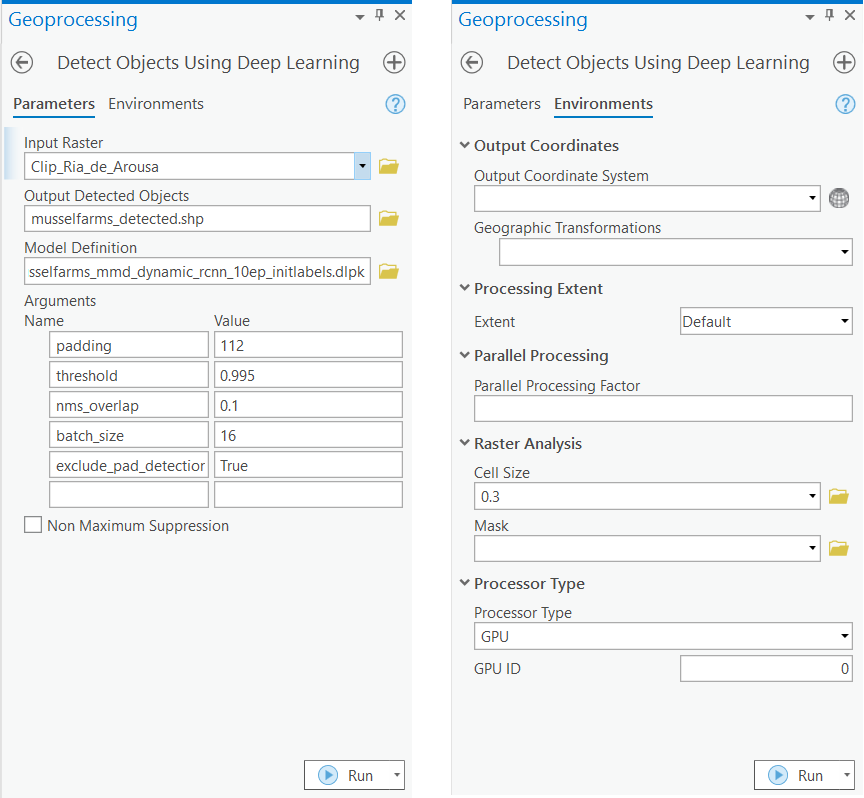 '>
    <br>
    <center>
    <figcaption>Detect Objects Using Deep Learning </figcaption>
    </center>
</figure>

### Results

The model was run on the entire Ria De Arousa region and the results can be viewed here.

<Item title:"musselfarms_detected" type:Feature Layer Collection owner:demos_deldev>
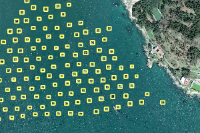

In [20]:
#get feature layer using item id
fc = gis.content.get('477d756f79e4400fa91c5b220406d98c')
fc

<Item title:"mussel_farm_detection" type:Web Map owner:demos_deldev>
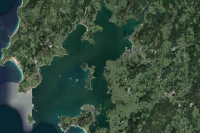

In [21]:
#get webmap using item id
wm_item = gis.content.get('36714d14f80649e99aaf702f3cec6455')
wm_item

In [22]:
#Create map object with webmap layer
mapp = gis.map(wm_item) 

# Add feature layer over map
mapp.content.add(fc)

# Zoom to the feature layer extent
mapp.zoom_to_layer(fc) 

# Display map
mapp 

<figure>    
   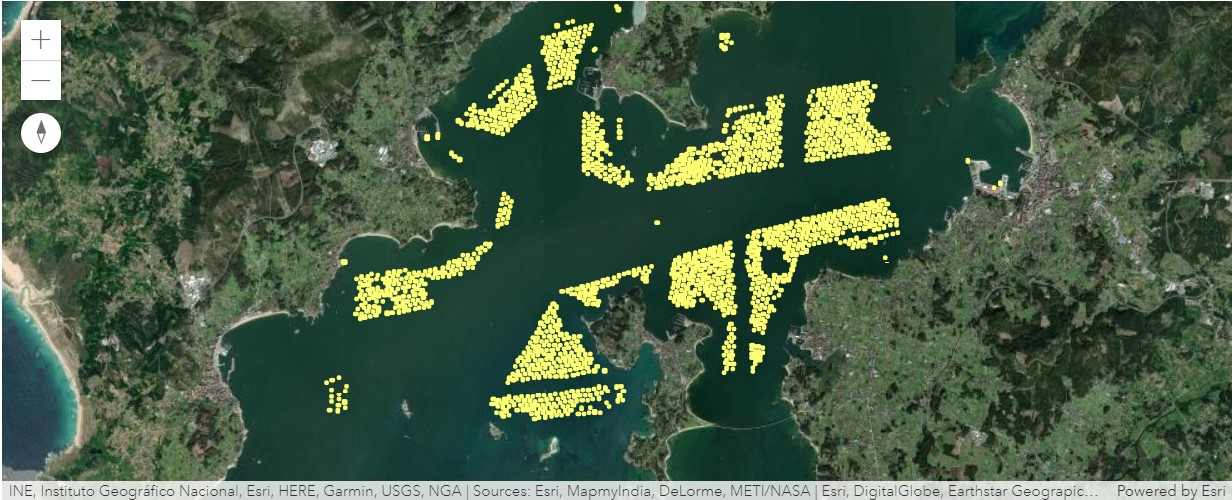
</figure> 

## Conclusion

In this notebook, we saw how we can use deep learning and high-resolution satellite imagery to detect mussel farms. This can be an important task for monitoring and conservation purposes. We used a small sample as training data with one of the object detection models available through the MMDetection integration in `arcgis.learn`. We trained the deep learning model for a few iterations and then deployed it to detect all the mussel farms in the Ria De Arousa region. To save time and resources we used a model builder that clipped out a raster containing only the water body. This clipped raster was used to detect the farms. The results are highly accurate and almost all the mussel farms in the region have been detected.